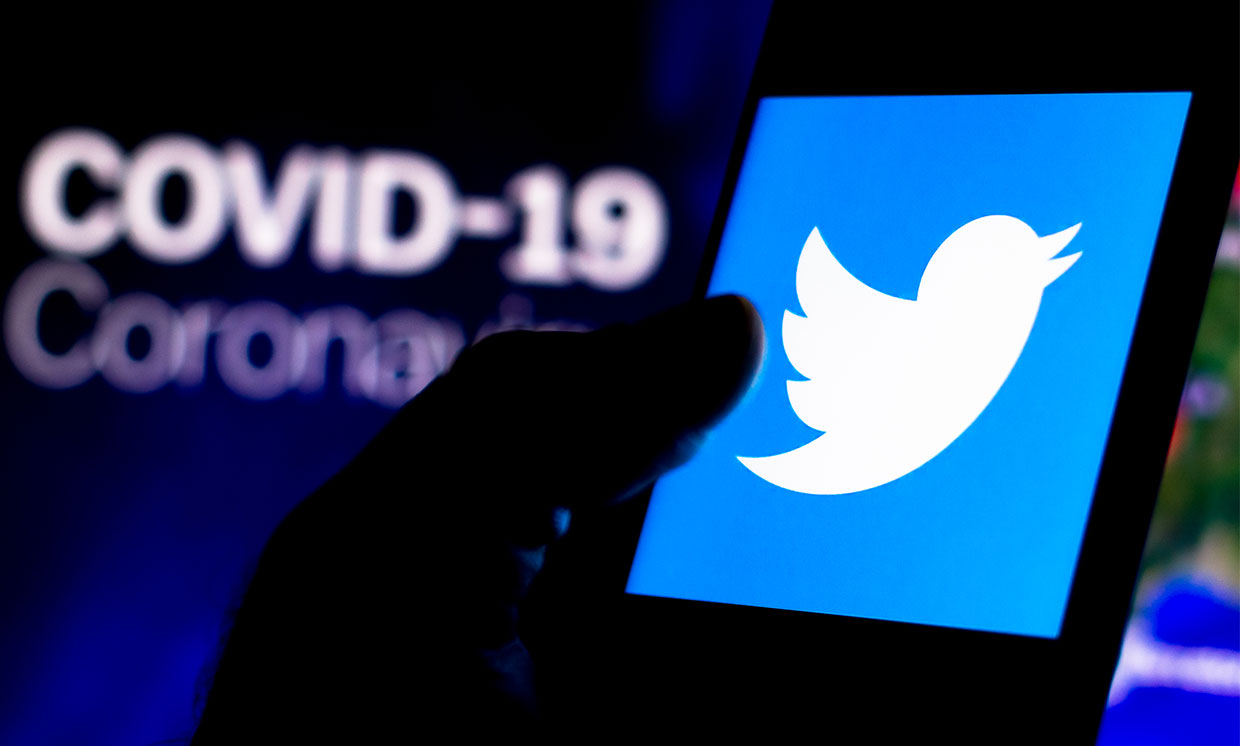

#**Predicting COVID case rate change by US state using Big Twitter Data**

[Logan Ayliffe](mailto:lmayliffe@gmail.com), Ellen Gao, Rebecca Sassower

A few notes before we begin.

Firstly, this notebook relies on a few files for data, and assumes that you have uploaded these to your google drive account already. In accordance with the Twitter Academic Research Track API, we do not make the full tweet objects publicly available. To run this notebook with our data, please contact me via email to discuss.

Secondly, this project was initially completed for graduate school at University of Pennsylvania. As such, there may be references to "project scope" and whatnot. I (Logan Ayliffe) have updated it for readability and ease of use, but the odd reference may remain. 

Lastly, I am so grateful to my team members for their strong contributions to this project. My work is primarily focused on obtaining the large Twitter dataset ([Step 2.1](https://colab.research.google.com/drive/15mSxuqYsAFGOqCOR4jE62KayFR9oG7sm?authuser=2#scrollTo=mrCnmoWX7qhy&line=3&uniqifier=1)) as well as the ML models and results relating to ngram usage ([Step 4](https://colab.research.google.com/drive/15mSxuqYsAFGOqCOR4jE62KayFR9oG7sm?authuser=2#scrollTo=VbiMCB3p_56I)).


## Introduction

The [World Well-Being Project](http://wwbp.org/) is an inter-disciplinary effort among computer scientists, psychologists, and statisticians. Based out of the University of Pennsylvania’s Positive Psychology Center and Stony Brook University’s Human Language Analysis Lab, the WWBP develops scientific and programmatic methods for measuring physical and psychological health using social media data.

We were inspired by the great work that the WWBP does in the health outcomes space. For example, the researchers at the WWBP has successfully demonstrated that machine learning models trained on twitter data are able to predict [heart disease mortality rates](https://cardio.jmir.org/2021/1/e24473) and [excessive alcohol use.](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0194290)

Following in that theme, we were interested to investigate if there is a correlation between twitter data and COVID case rates. In the end, we did find a strong correlation between TFIDF scores for twitter ngrams + COVID case rates, as well as sentiment scores and COVID case rates.


## Strategy
**Datasets**
1.   Publicly available COVID case rate and death rate datasets pulled from the CDC
2.   Twitter dataset manually curated from Twitter API

**Task**

Explore meaningful dataset creation between date/state-based tweets and date/state-based COVID stats, March 2020 - March 2021, and explore the explanatory power of tweets over COVID stats.

**Experiments**

 We experimented with tweet sentiment analysis - first comparing libraries' classifications, then using libraries' scores as features for ML, and finally using a TF-IDF Vectorizer as features for ML. We then simultaneously experimented with ML models using various features and labels from the following lists:
- Features: State, Year, Month, Sentiment score aggregated over state and month, Most frequently occuring n-grams aggregated over state and month
- Labels: Monthly COVID case count by state, Percentage Change in Monthly COVID case count by state

**Performance Metrics**: 

For sentiment analysis in which the sentiment label is a category (positive vs negative vs neutral), we used accuracy as the standard metric of performance for classification models. For all regression models, in which the sentiment label is a float [-1,1] or excluding sentiment analysis, we use MSE and R2 scores for performance evaluation.

For ngram machine learning models, we assess performance by calculating the Pearson Product Moment Correlational Coefficient. We compare our models'performance to a random baseline.

## Step 0: Imports
Install required packages for Pandas Dataframes, data visualizations, & ML models.

In [ ]:
%%capture
!pip3 install lxml
!pip install pandasql
!pip install googledrivedownloader
!pip install --upgrade geopandas
import numpy as np
import pandas as pd
import matplotlib
import gc
import time
import warnings
import networkx as nx
import pandas as pd
import numpy as np
import pandasql as ps
import json
from lxml import etree
import urllib
import geopandas 
import sqlite3
import pandasql as ps
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
!pip install textblob
!pip install vaderSentiment
import textblob
from textblob import TextBlob
!python -m textblob.download_corpora
import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
from textblob.sentiments import NaiveBayesAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, f1_score
import re
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Step 1: CDC Datasets - Wrangling, Cleaning, and Shaping
In this section, we load the CDC dataset, clean and preprocess them into a format that allows for efficient merging with the Twitter dataset in later sections, and conduct exploratory data analysis by providing general desciptors and creating several useful visualizations of the dataset.

Specifically, the datasets that we use to extract COVID-19 related information - '/content/drive/MyDrive/time_series_covid19_confirmed_US_cleaned.csv' contain time series raw COVID-19 case counts by state. In this project, we focus on a 13-month rolling period from 2020-02 to 2021-03 for our analysis purposes. 


### Step 1.1: Load CDC Datasets

In [ ]:
# Load CDC Case Count Dataset: cdc_cases_df

geo_df = pd.read_csv('/content/drive/MyDrive/geopandas_testdata.csv') #geopandas test data
cdc_cases_df = pd.read_csv('/content/drive/MyDrive/time_series_covid19_confirmed_US_cleaned.csv')
cdc_cases_df = cdc_cases_df.dropna()
cdc_cases_df.head()

### Step 1.2: Formatting/Preprocessing
In this section, we format 'time_series_covid19_confirmed_US_cleaned.csv' by:

1.   Dropping irrelevant columns: 'UID', 'iso2', 'iso3', 'code3'
2.   Truncating the 'FIPS' column to a standardized 5-digit format 
3.   Aggregating the data by state and counting the total COVID cases per state
4.   Transposing the dataframes so that we have a column vector for all the states and each row contains the data for a specific date. This allows for easy merging when we combine the COVID datasets with the Twitter dataset in later sections 
5.   Aggregating the data by monthYear so that we have a more zoomed-out view of COVID case rates month over month



















In [ ]:
# Formatting cdc_cases_df

cdc_cases_df['FIPS'] = cdc_cases_df['FIPS'].astype(str)
cdc_cases_df['FIPS'] = cdc_cases_df['FIPS'].apply(lambda x: x.split('.')[0])

cases_by_state_df = cdc_cases_df.groupby('Province_State').sum()
cases_by_state_df

In [ ]:
# Reformat for Merging with Twitter Dataset

## Column headers as dates
cases_by_state_df_test = cases_by_state_df.drop(columns=["Lat", "Long_", "UID", "code3"])
cases_by_state_df_columns = pd.Series(list(cases_by_state_df_test.columns.values))
cases_by_state_df_columns = pd.to_datetime(cases_by_state_df_columns, infer_datetime_format=True)
cases_by_state_df_columns = cases_by_state_df_columns.dt.strftime("%m/%d/%Y")
cases_by_state_df_test.columns = cases_by_state_df_columns

## Transpose
cases_by_state_df_test = cases_by_state_df_test.transpose()

## Date as column
cases_by_state_df_test.reset_index(inplace=True)
cases_by_state_df_test.rename(columns={"index": "date"}, inplace=True)

cases_by_state_df_test


In [ ]:
## Reformat for Merging with Monthly Agg Twitter Dataset

cases_by_state_monthly_df = cases_by_state_df_test
cases_by_state_monthly_df['date'] = pd.to_datetime(cases_by_state_monthly_df['date'], infer_datetime_format=True)
cases_by_state_monthly_df = cases_by_state_monthly_df.groupby([cases_by_state_monthly_df['date'].dt.year, cases_by_state_monthly_df['date'].dt.month]).sum()
cases_by_state_monthly_df.index.names = ["Year", "Month"]
cases_by_state_monthly_df.reset_index(level=[0,1], inplace=True)
cases_by_state_monthly_df

### Step 1.3: Exploratory Data Analysis

In this section, we perform exploratory data analysis on the COVID case count dataset by generating descriptive statistics for all the columns in the dataframe: descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution.



In [ ]:
# COVID case rate data by month by state

cases_by_state_monthly_df

In [ ]:
cases_by_state_monthly_df.describe()

### Step 1.5: Dataset Visualizations
In this section, we create several visualizations to provide different perspectivs of the data:

1.  We sort the states by the number of total COVID cases over the 13-month period in descending order, break them into groups of 10, and plot the trend of their COVID case rates over the course of 12 months

2.  We split the states up by geographic region, and plot the trend of their COVID case rates over the course of 13 months to examine patterns/abnormalities based on geographic region

3.  We provide any interactive user with the colab workbook the opportunity to zoom into any specific state and examine its case rate trend over the 13-month period 

3.  We split the data by quarter and plot the total COVID case rate for each state for each quarter. This allows us to examine any overall trends and individual state trend in case rate quarter over quarter


#### State Case Rate Trends


In [ ]:
# Rank the states by total COVID case rate over the rolling 12-month period, and plot state trends in groups of 10

cases_by_state_monthly_df['date'] = pd.to_datetime(cases_by_state_monthly_df[['Year', 'Month']].assign(DAY=1))
sum_column = cases_by_state_monthly_df.sum(axis=0)

## Top 10 states 
top_10_list = sum_column.sort_values(ascending=False).head(10).index.tolist()
top_10_list.append('date')
top_10_plot = cases_by_state_monthly_df[top_10_list]
top_10_plot.groupby('date').sum()
top_10_plot = top_10_plot.set_index('date')
labels = top_10_plot.columns
plt.figure(figsize=(10,6))
plt.plot(top_10_plot)
plt.legend(labels)
plt.title('Top 10 States')
plt.show()

## Top 10 - 20 states 
top_20_list = sum_column.sort_values(ascending=False).index.tolist()[10:20]
top_20_list.append('date')
top_20_plot = cases_by_state_monthly_df[top_20_list]
top_20_plot.groupby('date').sum()
top_20_plot = top_20_plot.set_index('date')
labels = top_20_plot.columns
plt.figure(figsize=(10,6))
plt.plot(top_20_plot)
plt.legend(labels)
plt.title('Top 10 - 20 States')
plt.show()

## Top 20 - 30 states
top_30_list = sum_column.sort_values(ascending=False).index.tolist()[20:30]
top_30_list.append('date')
top_30_plot = cases_by_state_monthly_df[top_30_list]
top_30_plot.groupby('date').sum()
top_30_plot = top_30_plot.set_index('date')
labels = top_30_plot.columns
plt.figure(figsize=(10,6))
plt.plot(top_30_plot)
plt.legend(labels)
plt.title('Top 20 - 30 States')
plt.show()

# Top 30 - 40 states
top_40_list = sum_column.sort_values(ascending=False).index.tolist()[30:40]
top_40_list.append('date')
top_40_plot = cases_by_state_monthly_df[top_40_list]
top_40_plot.groupby('date').sum()
top_40_plot = top_40_plot.set_index('date')
labels = top_40_plot.columns
plt.figure(figsize=(10,6))
plt.plot(top_40_plot)
plt.legend(labels)
plt.title('Top 30 - 40 States')
plt.show()

## Bottom 10 states 
top_50_list = sum_column.sort_values(ascending=False).index.tolist()[40:50]
top_50_list.append('date')
top_50_plot = cases_by_state_monthly_df[top_50_list]
top_50_plot.groupby('date').sum()
top_50_plot = top_50_plot.set_index('date')
labels = top_50_plot.columns
plt.figure(figsize=(10,6))
plt.plot(top_50_plot)
plt.legend(labels)
plt.title('Top 40 - 50 States')
plt.show()



#### Region Case Rate Trends


In [ ]:
# Split states into groups by geographic region and plot state trends over the rolling 12-month period   

## Northeast Region 
cases_by_state_monthly_df
northeast_states = ['Maryland', 'Delaware', 'New Jersey', 'Pennsylvania', 'Connecticut', 'Rhode Island', 'New York', 'Massachusetts', 'Vermont', 'New Hampshire', 'Maine', 'date']
northeast_plot = cases_by_state_monthly_df[northeast_states]
northeast_plot.groupby('date').sum()
northeast_plot = northeast_plot.set_index('date')
labels = northeast_plot.columns
plt.figure(figsize=(10,6))
plt.plot(northeast_plot)
plt.legend(labels)
plt.title('Northeast Region')
plt.show()

## Midwest Region 
midwest_states = ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin', 'date']
midwest_plot = cases_by_state_monthly_df[midwest_states]
midwest_plot.groupby('date').sum()
midwest_plot = midwest_plot.set_index('date')
labels = midwest_plot.columns
plt.figure(figsize=(10,6))
plt.plot(midwest_plot)
plt.legend(labels)
plt.title('Midwest Region')
plt.show()

#Southeast Resion
southeast_states = ['Alabama', 'Florida', 'Georgia', 'Kentucky', 'Maryland', 'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee', 'Virginia', 'West Virginia', 'date']
southeast_plot = cases_by_state_monthly_df[southeast_states]
southeast_plot.groupby('date').sum()
southeast_plot = southeast_plot.set_index('date')
labels = southeast_plot.columns
plt.figure(figsize=(10,6))
plt.plot(southeast_plot)
plt.legend(labels)
plt.title('Southeast Region')
plt.show()

#Southwest Region
southwest_states = ['Arizona', 'New Mexico', 'Texas', 'Oklahoma', 'date']
southwest_plot = cases_by_state_monthly_df[southwest_states]
southwest_plot.groupby('date').sum()
southwest_plot = southwest_plot.set_index('date')
labels = southwest_plot.columns
plt.figure(figsize=(10,6))
plt.plot(southwest_plot)
plt.legend(labels)
plt.title('Southwest Region')
plt.show()


## Western Region
western_states = ['Alaska', 'Arizona', 'California', 'Hawaii', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming', 'date']
western_plot = cases_by_state_monthly_df[western_states]
western_plot.groupby('date').sum()
western_plot = western_plot.set_index('date')
labels = western_plot.columns
plt.figure(figsize=(10,6))
plt.plot(western_plot)
plt.legend(labels)
plt.title('Western Region')
plt.show()

#### Single State Case Rate Trend


In [ ]:
# Zoom into a specific state, user can select any state column to view the statistics for that state 

import seaborn as sns
state_plot = cases_by_state_monthly_df[['Pennsylvania', 'date']]
state_plot = state_plot.groupby('date').sum()
plt.figure(figsize=(10, 8))
plt.title("Case Count over Time - Pennsylvania")
sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightblue'})
sns.lineplot(data=state_plot, x="date", y="Pennsylvania")


#### Quarterly Case Rate Trends

In [ ]:
# Split the data by quarters and look at how the country and each state changed over each quarter

## 2nd quarter 2020
quarterly_plot2 = cases_by_state_monthly_df.loc[(cases_by_state_monthly_df['date'] < '2020-07-01')]
quarterly_sum2 = quarterly_plot2.sum(axis = 0).to_frame()
quarterly_sum2 = quarterly_sum2.transpose()
quarterly_sum2 = quarterly_sum2.drop(columns=['Year', 'Month'])
plt.figure(figsize=(65, 12))
sns.barplot(data = quarterly_sum2).set_title('2nd Quarter 2020', fontsize=50)

## 3rd quarter 2020
quarterly_plot3 = cases_by_state_monthly_df.loc[(cases_by_state_monthly_df['date'] >= '2020-07-01')
                     & (cases_by_state_monthly_df['date'] < '2020-10-01')]
quarterly_sum3 = quarterly_plot3.sum(axis = 0).to_frame()
quarterly_sum3 = quarterly_sum3.transpose()
quarterly_sum3 = quarterly_sum3.drop(columns=['Year', 'Month'])
plt.figure(figsize=(65, 12))
sns.barplot(data = quarterly_sum3).set_title('3rd Quarter 2020', fontsize=50)

## 4th quarter 2020
quarterly_plot4 = cases_by_state_monthly_df.loc[(cases_by_state_monthly_df['date'] >= '2020-10-01')
                     & (cases_by_state_monthly_df['date'] < '2021-01-01')]
quarterly_sum4 = quarterly_plot4.sum(axis = 0).to_frame()
quarterly_sum4 = quarterly_sum4.transpose()
quarterly_sum4 = quarterly_sum4.drop(columns=['Year', 'Month'])
plt.figure(figsize=(65, 12))
sns.barplot(data = quarterly_sum4).set_title('4th Quarter 2020', fontsize=50)

## 1st quarter 2021
quarterly_plot1 = cases_by_state_monthly_df.loc[(cases_by_state_monthly_df['date'] >= '2021-01-01')
                     & (cases_by_state_monthly_df['date'] <= '2021-03-01')]
quarterly_sum1 = quarterly_plot1.sum(axis = 0).to_frame()
quarterly_sum1 = quarterly_sum1.transpose()
quarterly_sum1 = quarterly_sum1.drop(columns=['Year', 'Month'])
plt.figure(figsize=(65, 12))
sns.barplot(data = quarterly_sum1).set_title('1st Quarter 2021', fontsize=50)


#### Top Growth States


In [ ]:
# From the above graphs, we can see that California, Florida, and Texas showed the most drastic changes in the positive direction (increase in case rate) in 2020. Let's zoom into these three states here:

## 2nd quarter 2020
top_growth_2 = quarterly_sum2[['California', 'Florida', 'Texas']]
plt.figure(figsize=(5, 3))
plt.ylim(0, 310000000)
sns.barplot(data = top_growth_2).set_title('2nd Quarter 2020')

## 3rd quarter 2020
top_growth_3 = quarterly_sum3[['California', 'Florida', 'Texas']]
plt.figure(figsize=(5, 3))
plt.ylim(0, 310000000)
sns.barplot(data = top_growth_3).set_title('3rd Quarter 2020')

## 4th quarter 2020
top_growth_4 = quarterly_sum4[['California', 'Florida', 'Texas']]
plt.figure(figsize=(5, 3))
plt.ylim(0, 310000000)
sns.barplot(data = top_growth_4).set_title('4th Quarter 2020')

## 1st quarter 2021
top_growth_1 = quarterly_sum1[['California', 'Florida', 'Texas']]
plt.figure(figsize=(5, 3))
plt.ylim(0, 310000000)
sns.barplot(data = top_growth_1).set_title('1st Quarter 2021')

## Line plot of 12-month trend of these 3 states 
top3_states = ['California', 'Florida', 'Texas', 'date']
top_growth_states = cases_by_state_monthly_df[top3_states]
top_growth_states.groupby('date').sum()
top_growth_states = top_growth_states.set_index('date')
labels = top_growth_states.columns
plt.figure(figsize=(10,6))
plt.plot(top_growth_states)
plt.legend(labels)
plt.title('Top Growth States')
plt.show()


#### Case Count Heat Maps


In [ ]:
march_heat_df = cases_by_state_monthly_df[cases_by_state_monthly_df['date'] == '2021-03-01']
march_heat_df = march_heat_df.drop(columns=['Year', 'Month', 'date']).transpose()
march_heat_df = march_heat_df.reset_index()

nov_heat_df = cases_by_state_monthly_df[cases_by_state_monthly_df['date'] == '2020-11-01']
nov_heat_df = nov_heat_df.drop(columns=['Year', 'Month', 'date']).transpose()
nov_heat_df = nov_heat_df.reset_index()

apr_heat_df = cases_by_state_monthly_df[cases_by_state_monthly_df['date'] == '2020-04-01']
apr_heat_df = apr_heat_df.drop(columns=['Year', 'Month', 'date']).transpose()
apr_heat_df = apr_heat_df.reset_index()

In [ ]:
spatial_df = geopandas.read_file("/content/drive/MyDrive/gz_2010_us_040_00_5m.json")
spatial_df.head()


In [ ]:
march_plot = spatial_df.merge(march_heat_df, left_on='NAME', right_on='Province_State', how='left').drop(columns=['Province_State'])
march_cases_gdf = geopandas.GeoDataFrame(march_plot)

fig, ax = plt.subplots(1, figsize=(15, 12))
plt.xlim(-190, -50)
plt.title('COVID Cases Heatmap - March 2021')
march_cases_gdf.plot(column=13, ax=ax, legend=True, legend_kwds={'shrink': 0.2}, cmap='OrRd')

nov_plot = spatial_df.merge(nov_heat_df, left_on='NAME', right_on='Province_State', how='left').drop(columns=['Province_State'])
nov_cases_gdf = geopandas.GeoDataFrame(nov_plot)

fig, ax = plt.subplots(1, figsize=(15, 12))
plt.xlim(-190, -50)
plt.title('COVID Cases Heatmap - Nov 2020')
nov_cases_gdf.plot(column=9, ax=ax, legend=True, legend_kwds={'shrink': 0.2}, cmap='OrRd')

apr_plot = spatial_df.merge(apr_heat_df, left_on='NAME', right_on='Province_State', how='left').drop(columns=['Province_State'])
apr_cases_gdf = geopandas.GeoDataFrame(apr_plot)

fig, ax = plt.subplots(1, figsize=(15, 12))
plt.xlim(-190, -50)
plt.title('COVID Cases Heatmap - Apr 2020')
apr_cases_gdf.plot(column=2, ax=ax, legend=True, legend_kwds={'shrink': 0.2}, cmap='OrRd')

## Step 2: Twitter Datasets - Wrangling, Cleaning, and Shaping

The first step in wrangling our Twitter data was to specify exactly what sort of dataset we wanted. We knew that we wanted tweets over a significant (6 months or more) timespan during the pandemic. We also wanted tweets that were related to the pandemic in some way. We wanted tweets that we could link to a physical place in the world. We also wanted a large dataset, at least of the size "10s of thousands of rows, 10s of columns."

These four criteria ended up being difficult to reconcile.

1. Time-duration
2. Relevance to COVID
3. Geolocated
4. Big








### Step 2.1 Exploring different Twitter datasets
We began by considering a dataset from PanaceaLab out of Georgia State University. 

#### PanaceaLabs 
[ [website](http://www.panacealab.org/covid19/), [github](https://github.com/thepanacealab/covid19_twitter) ]

1. Time-duration: This dataset produces daily output, beginning 3/22/2020 and continuing to the current day. 
2. Relevance to COVID: the researchers quantified COVID relevance by scraping tweets using a set of keywords joined by OR statements. The set is `COVD19, CoronavirusPandemic, COVID-19, 2019nCoV, CoronaOutbreak,coronavirus , WuhanVirus, covid19, coronaviruspandemic, covid-19, 2019ncov, coronaoutbreak, wuhanvirus. `
3. Geolocated: the first signs of trouble showed up here. Fewer than 1% of this dataset included tweets with geotags, and the researchers didn't make the geolocation information available in their release.
4. Big - this dataset is VERY BIG. They are collecting about 4million tweets / day, for more than a year.

It is point #3 that was the deal-killer for this dataset. We could compromise on the time duration and size, and we could accept different methods of linking tweets to the pandemic, but we required geolocation as part of our dataset. So unfortunately this set was out.

#### George Washington University TweetSets
[ [website](https://tweetsets.library.gwu.edu/), [dataset](https://tweetsets.library.gwu.edu/dataset/8b9a5e39) ]

1. Time-duration: This dataset covers 3/3/2020 - 12/3/2020. This was a bit of a bummer as we were really interested in exploring potential changes in sentiment once vaccine availability really kicked into gear, but we were willing to compromise.
2. Relevance to COVID: the researches also used a keyword match strategy, on hashtags only, to quantify relevance to COVID, but with a much smaller keyword set. The set was `#Coronavirus, #COVID19, #CoronaOutbreak.`
3. Geolocated: we were able to specify only geotagged tweets when pulling the dataset, so we were good here -- or so we thought.
4. Size: the main set is very large - 354,903,485 tweets in total. After specifying only geotagged tweets, our final dataset was 1,544,700, about 0.4% of the total.

With hope in our hearts, we fired up [Hydrator](https://github.com/DocNow/hydrator) and began re-hydrating our tweet IDs from this dataset. So far, so good!

After about 8 hours (re-hydrating tweets is subject to rate limitations when hitting the Twitter API) our full json objects were ready for inspection. That's when we realized the problem. 

While we were only using geotagged tweets, they could be geotagged **anywhere**. Doing some exploratory data analysis, we realized that only a small percentage of the tweets were geotagged in the US, much less distributed across the 50 states in the US. Disaster! This dataset is useless for our project.

#### Screw it , we'll do it ourselves!

At this point we were getting a bit frustrated. The main thing working against us was the fact that Twitter changed the way that geotagging works on their app back in the mid 2010s -- what used to be opt-out, was now opt-in. As a result, researchers around the planet suddenly found that getting high quality datasets with geotagged tweets was very difficult. 

We decided that in order to solve the problem, we'd be best served by learning how to scrape the tweets ourselves. So we headed over to the Twitter API and...couldn't do it.

Turns out, Twitter has many, many different types of APIs and API access levels. The most commonly used one is a streaming api where one can capture new tweets in real time. This wasn't useful for us, as we needed to be able to scrape tweets from the past, ideally March 2020 through March 2021. The second most common one does allow for search, but only up to 7 days in the past.

Then we found the [Full Archive Search API](https://developer.twitter.com/en/docs/twitter-api/tweets/search/introduction) access track! Wonderful! This looked like it would be exactly what we needed. One problem: it was restricted and in order to get access, we had to apply for the Academic Research Application.

It took about a week and a half, going back and forth with Twitter support to prove our identity, describe the nature of our work, and promise not to violate ther ToS. Finally, access was granted! We could do it!

1. Time-duration: We could determine this ourselves! So we went for the full year that we'd been hoping for all along, March 2020 through March 2021.
2. Relevance to COVID: we could use whatever metric we wanted! In the end, we decided to use keyword match with OR clauses just like PanaceaLabs. There's definitely a lot of sets that use different strategies, e.g. restricting scraping to a subset of specific accounts that are identified as being domain relevant, e.g. the CDC. But for us, we wanted to cast a wide net and get the data of everyone, not just experts. Our final keyword set was `COVID19 OR COVD19 OR covid19 OR CoronavirusPandemic OR COVID-19 OR covid-19 OR 2019nCoV OR CoronaOutbreak OR coronaoutbreak OR coronavirus OR WuhanVirus OR coronaviruspandemic OR wuhanvirus`. We also included a few other filters as controls: we restricted to tweets in English, no retweets, no ads, no URLs.
3. Geolocated: The Academic Research Track allows a subset of what Twitter calls Premium Operators, one of which is the Place operator. This lets us specify that a Tweet is associated with a Place - this can be either by the geotagging lat/long in the tweet that user included, or a handful of other place-determiners that Twitter abstracts behind the query parameter. So we're good!
4. Quantity: there wasn't a good way to estimate the final result set size from the beginning, but we felt confident that we'd hit our goal of Big Data. In the end, we did!


The final code used to scrape the tweets from the Full-Search endpoint is below. The full data pull took about 16.25 hours in total due to rate limits.

In [ ]:
import requests
import os
import json
import time

'''
RATE LIMITS 
10million tweets / month
1 request / second 
300 requests / 15 minutes

This last limit effectively means 1 request per 3 seconds.

50 states x 13 months x ~30 days per month = 19,500 requests
19,500 requests / 300 requests per 15 mins = 65 blocks
50 blocks * 15 mins = 975 mins or 16.25 hours

'''


# To set your environment variables in your terminal run the following line:
# export 'BEARER_TOKEN'='<your_bearer_token>'
bearer_token = os.environ.get("BEARER_TOKEN")


search_url = "https://api.twitter.com/2/tweets/search/all"

state_names = ["Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado",
               "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois",
               "Indiana", "Iowa", "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland",
               "Massachusetts", "Michigan", "Minnesota", "Mississippi", "Missouri", "Montana",
               "Nebraska", "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
               "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon", "Pennsylvania",
               "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
               "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"]

months_2020 = ['03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
months_2021 = ['01', '02', '03']
days = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14',
        '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']



def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers


def connect_to_endpoint(url, headers, params):
    response = requests.request(
        "GET", search_url, headers=headers, params=params)
    print(response.status_code)
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


def main():
    # top level dict
    all_json_responses = {}
    headers = create_headers(bearer_token)

    for state in state_names:
        # state level dict
        all_json_responses[state] = {}
        # rerun this with months_2021 for the 2021 pull
        for month in months_2020:
            # month level dict within state
            all_json_responses[state][month] = {}
            for day in days:
                try:
                    all_json_responses[state][month][day] = {}
                    query_params = {
                        'query': '(COVID19 OR COVD19 OR covid19 OR CoronavirusPandemic OR COVID-19 OR covid-19 OR 2019nCoV OR CoronaOutbreak OR coronaoutbreak OR coronavirus OR WuhanVirus OR coronaviruspandemic OR wuhanvirus)  -has:links has:geo -is:nullcast lang:en place_country:US -is:retweet place:' + state, 'max_results': 333, 'start_time': '2021-'+month+'-'+day+'T00:00:00Z', 'end_time': '2021-'+month+'-'+day+'T23:59:59Z', 'expansions': 'geo.place_id', 'tweet.fields': 'created_at'}
                    json_response = connect_to_endpoint(
                        search_url, headers, query_params)

                    all_json_responses[state][month][day] = json_response
                    time.sleep(3)
                except:
                    continue

        with open(state+'2021_data.json', 'w', encoding='utf-8') as f:
            json.dump(all_json_responses[state], f, indent=4, sort_keys=True)


# if __name__ == "__main__":
#     main()


### Step 2.2 Load Twitter Datasets

In this section, we load each of the state and year specific JSON files by:

1.   Writing a function that takes in a state's JSON file and returns a dataframe where each row is a tweet instance and the columns include embedded tweets' "created_at" timestamp, the "text" of the tweet, and state.
2.   Iteratively calling the function on each state's JSON file for 2020, then iteratively calling the function on each state's JSON file for 2021.
3.   Concatenating each returned state and year specific dataframe to one pandemic_tweets_df, at each iteration above, to create one dataframe for all scraped tweets.

While curating the twitter dataset of json files, we used the following publicly available twitter datasets from Kaggle - with sentiment category labels of positive, negative, or neutral - for sentiment analysis testing and as placeholders for merged training dataset experimentation:


1.   [Twitter Airline Sentiment Dataset](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)
2.   [Twitter Sentiment140 Dataset](https://www.kaggle.com/kazanova/sentiment140)


In [ ]:
# Function to pull every tweet's timestamp and full text from a single JSON file 

def json_to_df(json_path, state):
    tweets =[]
    with open(json_path) as json_file:
      tweet_data = json.load(json_file)

    state_tweets_df = pd.DataFrame()

    def element_generator(json_input, lookup_key):
        if isinstance(json_input, dict):
            for k, v in json_input.items():
                if k == lookup_key:
                    yield v
                else:
                    yield from element_generator(v, lookup_key)
        elif isinstance(json_input, list):
            for item in json_input:
                yield from element_generator(item, lookup_key)

    created_at_list = []
    text_list = []

    for _ in element_generator(tweet_data, "created_at"):
        created_at_list.append(_)

    for _ in element_generator(tweet_data, "text"):
        text_list.append(_)

    state_tweets_df["created_at"] = created_at_list
    state_tweets_df["text"] = text_list
    state_tweets_df["state"] = state
    
    return state_tweets_df

In [ ]:
# Loops to call the function above for every state, for each year (2020 & 2021) - to import twitter JSON files into one df

states = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
df_dict = {}
pandemic_tweets_df = pd.DataFrame()

for state in states:
  json_path = '/content/drive/MyDrive/2020_data/' + state + '2020_data.json'
  df_dict[state] = json_to_df(json_path, state)
  pandemic_tweets_df = pd.concat([df_dict[state],pandemic_tweets_df], ignore_index=True)

for state in states:
  json_path = '/content/drive/MyDrive/2021_data/' + state + '2021_data.json'
  df_dict[state] = json_to_df(json_path, state)
  pandemic_tweets_df = pd.concat([df_dict[state],pandemic_tweets_df], ignore_index=True)

pandemic_tweets_df

In [ ]:
# Load sentiment-category manually labeled "Airline Tweets" dataset, for testing

airline_tweets_df = pd.read_csv('/content/drive/MyDrive/AirlineTweets_States.csv')
airline_tweets_df

### Step 2.3 Formatting
In this section, we format the 'pandemic_tweets_df' and our testing placeholder dataframes by:

1.   Replacing the "created_at" timestamp column with a MM/DD/YYYY datetime column.
2.   Setting the "text" column's datatype to string.
3.   Additionally from the testing placeholder dataframes - Dropping superfluous columns and encoding the sentiment class label.


In [ ]:
# # pandemic_tweets_df - Replace "created_at" timestamp column with MM/DD/YYYY datetime column & Set "text" column's datatype to string

pandemic_tweets_df["date"] = pd.to_datetime(pandemic_tweets_df["created_at"], infer_datetime_format=True)
pandemic_tweets_df["date"] = pandemic_tweets_df["date"].dt.strftime("%m/%d/%Y")
pandemic_tweets_df["date"] = pd.to_datetime(pandemic_tweets_df["date"], infer_datetime_format=True)
pandemic_tweets_df = pandemic_tweets_df.drop(columns=["created_at"])
pandemic_tweets_df["text"] = pandemic_tweets_df["text"].astype('string') 
pandemic_tweets_df

In [ ]:
# Airline_tweets_df - Encode labeled sentiment categories & Drop columns not anticipated from curated twitter dataset

airline_tweets_df["text"] = airline_tweets_df["text"].astype('string')
sentiment_dict = {"negative": 0, "neutral": 2, "positive": 4} 
airline_tweets_df["airline_sentiment"] = airline_tweets_df["airline_sentiment"].map(sentiment_dict)
airline_tweets_df["date"] = pd.to_datetime(airline_tweets_df["tweet_created"], infer_datetime_format=True)
airline_tweets_df["date"] = airline_tweets_df["date"].dt.strftime("%m/%d/%Y")
airline_tweets_df = airline_tweets_df.drop(columns=["tweet_created", "tweet_coord", "negativereason", "negativereason_confidence", "airline_sentiment_gold", "negativereason_gold", "tweet_id", "airline", "name", "retweet_count", "user_timezone"])
airline_tweets_df.head()

In [ ]:
# Sentiment140_df - Name columns, set "text" column's datatype to string, and drop rows missing tweet text

# sentiment140_df.columns =['target', 'id', 'date', 'flag', 'user', 'text']
# sentiment140_df.dropna(subset=["text"], inplace=True)
# sentiment140_df["text"] = sentiment140_df["text"].astype('string') 

### Step 2.4 Preprocessing
In this section, we preprocess the 'pandemic_tweets_df' and our testing/placeholder dataframes.

First and foremost, we have a function for tweet text preprocessing, that forces all letters to lowercase, removes symbols like hashtag, removes punctuation, tokenizes the tweet string into wrods, removes stopwords, lemmatizes tokenized words, and drops one-word tweets. We apply the function above to the tweet text column and leverage one-hot encoding to encode the categorical state column.



In [ ]:
# Function for tweet text preprocessing

def preprocess_tweet_text(tweet):
    tweet = tweet.lower()  ## to lowercase
    tweet = re.sub(r'\@\w+|\#','', tweet)  ## remove symbols
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) ## remove punctuation
    tweet_tokens = word_tokenize(tweet)  ## tokenize strings into words
    stop_words = set(stopwords.words('english'))
    tokenized = [w for w in tweet_tokens if not w in stop_words]  ## remove stopwords
    lemmatizer = WordNetLemmatizer() 
    tokenized = [lemmatizer.lemmatize(w, pos='a') for w in tokenized]  ## lemmatize
    tokenized = [w for w in tokenized if w.isalpha() and len(w)>2]  ## drop one-word tweets 
    return " ".join(tokenized)

In [ ]:
# # Pandemic Tweets Text Preprocessing Function & One-Hot Encoding

pandemic_tweets_df["text"] = pandemic_tweets_df["text"].apply(preprocess_tweet_text)
pandemic_tweets_df = pd.get_dummies(pandemic_tweets_df, columns=["state"])
#save a copy for use in the ngram section
pandemic_tweets_copy = pandemic_tweets_df.copy()
pandemic_tweets_copy

Additionally for the testing/placeholder dataframe, we drop tweet instances that do not have the full tweet text (NaN in the text column). This step does not apply to our 'pandemic_tweets_df' because all scraped tweets have the tweet text.

In [ ]:
## Airline Tweets Text Preprocessing Function & One-Hot Encoding

airline_tweets_df.dropna(subset=["text"], inplace=True)
airline_tweets_df["text"] = airline_tweets_df["text"].apply(preprocess_tweet_text)
airline_tweets_df = pd.get_dummies(airline_tweets_df, columns=["tweet_location"])
airline_tweets_df.head()

Circling back after evaluating ML models prediction of Sentiment Classes (positive vs. negative vs neutral), we converted Sentiment Classes to Sentiment Floats (Scores) based on the Airline Tweets dataset's "Confidence Levels" column. The Airline Tweets dataset was manually labeled with Sentiment Classes; Since the "Confidence Levels" column reflects confidence in assigning each label, we extracted Sentiment Floats by multiplying the confidence level by 1 for *positive*, 0 for *neutral*, and -1 for *negative*.

In [ ]:
## Airline Dataset Label Processing - Use Sentiment Categories & Confidence Levels to get Sentiment Floats

sentiment_dict = {0: -1, 2: 0, 4: 1} ## Encoding
airline_tweets_df["airline_sentiment_category"] = airline_tweets_df["airline_sentiment"].map(sentiment_dict)
airline_tweets_df["airline_sentiment_float"] = airline_tweets_df["airline_sentiment_category"]*airline_tweets_df["airline_sentiment_confidence"]
airline_tweets_df.head()

In [ ]:
# ## Sentiment140 Text Preprocessing Function

# sentiment140_df["text"] = sentiment140_df["text"].apply(preprocess_tweet_text)
# sentiment140_df["text"]

### Step 2.5 Exploratory Data Analysis
In this section, we orient ourselves to the structure and size of our imported and preprocessed twitter dataset by:

1.   Checking out the first few instances of the dataframe.
2.   Generating descriptive statistics for all the columns in the dataframe. Descriptive statistics include those that summarize the central tendency, dispersion and shape of a dataset’s distribution. 

In [ ]:
pandemic_tweets_df.head(15)

In [ ]:
pandemic_tweets_df.describe()

### Step 2.6 Data Visualizations
In this section we visualize 


1.   Our loaded, formatted, processed pandemic_tweets_df's tweet text content through a wordcloud. 
2.   Our testing/placeholder labeled Airline Tweets dataframe's distribution of sentiment classes.


In [ ]:
# Pandemic Tweet Text Wordcloud

all_tweets = ' '.join(pandemic_tweets_df["text"])
all_tweets_wordcloud = WordCloud(width=800, height=400, colormap="plasma").generate(all_tweets)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(all_tweets_wordcloud)
plt.show()

In [ ]:
# Pandemic Tweet Text Wordcloud - Excluding COVID keywords used to find tweets and Twitter-specific "stopwords"
keywords = set(stopwords.words('english'))
keywords.update(["coronavirus", "covid", "covd19", "covid19", "coronaviruspandemic", "covid-19", "2019ncov", "coronaoutbreak", "coronaviruspandemic", "wuhanvirus", "pandemic", "one", "get", "like", "say", "know", "going", "still", "thing", "make", "also", "would", "said", "got", "let", "tell", "see", "come", "someone", "could", "yet", "think", "need", "much", "things", "look", "way", "want", "amp", "today", "told", "day", "really", "something", "well", "actually", "since", "keep", "getting", "anything", "everything", "dont", "saying", "taking", "take", "many", "thought", "already", "lot", "sure", "able", "month", "week", "year", "time"])
all_tweets = ' '.join(pandemic_tweets_df["text"])
all_tweets_wordcloud = WordCloud(width=800, height=400, stopwords=keywords, colormap="plasma").generate(all_tweets)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(all_tweets_wordcloud)
plt.show()

In [ ]:
# Airline Tweet Labeled Sentiment Distribution
airline_tweets_df["airline_sentiment_category"].value_counts().plot(kind='bar', title = "Airline Tweet Sentiment Distribution")

### Step 2.7 Sentiment Analysis
In order to predict the sentiment of a tweet we experimented with the following:

1.   Test 1: Compared the performance of TextBlob, Blobber, and Vader for sentiment predictions based on tweet text.
2.   Test 2: Used those libraries' scores as features for ML sentiment prediction.
3.   Test 3: Used TF-IDF Vectorizor as features for ML sentiment prediction. 

Initially, experimentation revolved around the test Kaggle datasets' categorical labels of positive/negative/neutral and, as such, took the form of classification, using accuracy as the metric for evaluation.

In order to explore more meaningful relationships between tweet sentiment and CDC covid stats, however, we circled back to experiment with sentiment labels as floats to capture the nuances of emotion along the spectrum between despair and hope. 

The manually labeled Airline Tweet dataset assigned each label a "confidence score" such that an obviously optimistic tweet like 


`
"*@VirginAmerica So excited for my first cross country flight LAX to MCO I've heard nothing but great things about Virgin America. #29DaysToGo*"
`


 got a confidence score of 1 for being positive, while a potentially unsatisfied statement of fact like 
 
 `
"*@VirginAmerica SFO-PDX schedule is still MIA.*"
`
 
  got a confidence score of 0.6842 for being negative. Multiplying the sentiment label - 1 for positive/neutral, -1 for negative - by the confidence score, yielded our sentiment score. 

With the sentiment score, we repeated the sentiment analysis experiments for comparison. To zoom out from individual pandemic-related tweets, in order to use tweets as a pulse on regional sentiment for ML experiementation on our eventual training dataset of pandemic-related tweets and CDC covid stats, we aggregated sentiment scores by state and by month. 



##### Test 1: Sentiment Analysis Libraries
For both sentiment classification of categorical labels and sentiment regression for float labels, we are using out-of-the-box sentiment analysis libraries on the labeled airline tweets dataset as our baselines for performance.

In [ ]:
## TextBlob Sentiment Analysis on Tweets

def sentiment_of_polarity(x):
  if x > 0.05:
      return 4 ##positive
  elif x < -0.05:
      return 0 ##negative
  else:
      return 2 ##neutral

In [ ]:
## Covid Tweet TextBlob
pandemic_tweets_df["textblob_polarity"] = pandemic_tweets_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
pandemic_tweets_df["textblob_sentiment"] = pandemic_tweets_df["textblob_polarity"].apply(sentiment_of_polarity)
pandemic_tweets_df["textblob_subjectivity"] = pandemic_tweets_df["text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
## AirlineTweets TextBlob
airline_tweets_df["textblob_polarity"] = airline_tweets_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
airline_tweets_df["textblob_sentiment"] = airline_tweets_df["textblob_polarity"].apply(sentiment_of_polarity)
airline_tweets_df["textblob_subjectivity"] = airline_tweets_df["text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
# ## Sentiment140 TextBlob
# sentiment140_df["textblob_polarity"] = sentiment140_df["text"].apply(lambda x: TextBlob(x).sentiment.polarity)
# sentiment140_df["textblob_sentiment"] = sentiment140_df["textblob_polarity"].apply(sentiment_of_polarity)
# sentiment140_df["textblob_subjectivity"] = sentiment140_df["text"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
## Blobber Sentiment Analysis on Tweets

tb = textblob.Blobber(analyzer=NaiveBayesAnalyzer()) 
def classification_adjustment(x):
  if x == "pos":
      return 4 ##positive
  elif x == "neg":
      return 0 ##negative
  else:
      return 2 ##neutral

In [ ]:
## Covid Tweet Blobber
pandemic_tweets_df["blobber_classification"] = pandemic_tweets_df["text"].apply(lambda x: tb(x).sentiment.classification)
pandemic_tweets_df["blobber_sentiment"] = pandemic_tweets_df["blobber_classification"].apply(classification_adjustment)
sentiment_dict = {"neg": 0, "pos": 4} ## Encoding
pandemic_tweets_df["blobber_classification"] = pandemic_tweets_df["blobber_classification"].map(sentiment_dict)
pandemic_tweets_df

In [ ]:
## AirlineTweets Blobber
airline_tweets_df["blobber_classification"] = airline_tweets_df["text"].apply(lambda x: tb(x).sentiment.classification)
airline_tweets_df["blobber_sentiment"] = airline_tweets_df["blobber_classification"].apply(classification_adjustment)
sentiment_dict = {"neg": 0, "pos": 4} ## Encoding
airline_tweets_df["blobber_classification"] = airline_tweets_df["blobber_classification"].map(sentiment_dict)
airline_tweets_df

In [ ]:
# ## Sentiment140 Blobber
# sentiment140_df["blobber_classification"] = sentiment140_df["text"].apply(lambda x: tb(x).sentiment.classification)
# sentiment140_df["blobber_sentiment"] = sentiment140_df["blobber_classification"].apply(classification_adjustment)

In [ ]:
## Vader Sentiment Analysis on Tweets

def pos_vs_neg(x):
  if x['vader_pos_score'] > x['vader_neg_score']:
    return 4 ##positive
  elif x['vader_pos_score'] < x['vader_neg_score']:
    return 0 ##negative
  else:
    return 2 ##neutral

analyser = SentimentIntensityAnalyzer()

In [ ]:
## Covid Tweets Vader
pandemic_tweets_df["vader_neg_score"] = pandemic_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["neg"])
pandemic_tweets_df["vader_pos_score"] = pandemic_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["pos"])
pandemic_tweets_df["vader_neu_score"] = pandemic_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["neu"])
pandemic_tweets_df["vader_comp_score"] = pandemic_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["compound"])
pandemic_tweets_df["vader_sentiment"] = pandemic_tweets_df.apply(pos_vs_neg, axis=1)

In [ ]:
## AirlineTweets Vader
airline_tweets_df["vader_neg_score"] = airline_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["neg"])
airline_tweets_df["vader_pos_score"] = airline_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["pos"])
airline_tweets_df["vader_sentiment"] = airline_tweets_df.apply(pos_vs_neg, axis=1)
airline_tweets_df["vader_neu_score"] = airline_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["neu"])
airline_tweets_df["vader_comp_score"] = airline_tweets_df["text"].apply(lambda x: analyser.polarity_scores(x)["compound"])

In [ ]:
# ## Sentiment140 Vader
# sentiment140_df["vader_neg_score"] = sentiment140_df["text"].apply(lambda x: analyser.polarity_scores(x)["neg"])
# sentiment140_df["vader_pos_score"] = sentiment140_df["text"].apply(lambda x: analyser.polarity_scores(x)["pos"])
# sentiment140_df["vader_sentiment"] = sentiment140_df.apply(pos_vs_neg, axis=1)
# sentiment140_df["vader_neu_score"] = sentiment140_df["text"].apply(lambda x: analyser.polarity_scores(x)["neu"])
# sentiment140_df["vader_comp_score"] = sentiment140_df["text"].apply(lambda x: analyser.polarity_scores(x)["compound"])

In [ ]:
## Sentiment Analysis Metrics Comparison - Category Labels

def textblob_accuracy(true_labels, predicted_labels):
    print(f'TextBlob Accuracy: {100.* accuracy_score(true_labels, predicted_labels):.4f},',
      f'TextBlob F1 Score: {100.* f1_score(true_labels, predicted_labels, average="weighted"):.4f}')
    return

def blobber_accuracy(true_labels, predicted_labels):
    print(f'Blobber Accuracy: {100.* accuracy_score(true_labels, predicted_labels):.4f},',
      f'Blobber F1 Score: {100.* f1_score(true_labels, predicted_labels, average="weighted"):.4f}')
    return

def vader_accuracy(true_labels, predicted_labels):
    print(f'Vader Accuracy: {100.* accuracy_score(true_labels, predicted_labels):.4f},',
      f'Vader F1 Score: {100.* f1_score(true_labels, predicted_labels, average="weighted"):.4f}')
    return

In [ ]:
## Airline Tweets Metrics Comparison - Category Labels

textblob_airline_predicted = airline_tweets_df['textblob_sentiment'].tolist()
textblob_airline_true = airline_tweets_df['airline_sentiment'].tolist()
textblob_accuracy(textblob_airline_true, textblob_airline_predicted)

blobber_airline_predicted = airline_tweets_df['blobber_sentiment'].tolist()
blobber_airline_true = airline_tweets_df['airline_sentiment'].tolist()
blobber_accuracy(blobber_airline_true, blobber_airline_predicted)

vader_airline_predicted = airline_tweets_df['vader_sentiment'].tolist()
vader_airline_true = airline_tweets_df['airline_sentiment'].tolist()
vader_accuracy(vader_airline_true, vader_airline_predicted)

In [ ]:
# ## Sentiments140 Metrics Comparison - Category Labels
# textblob_airline_predicted = sentiment140_df['textblob_sentiment'].tolist()
# textblob_airline_true = sentiment140_df['target'].tolist()
# textblob_accuracy(textblob_airline_true, textblob_airline_predicted)

# blobber_airline_predicted = sentiment140_df['blobber_sentiment'].tolist()
# blobber_airline_true = sentiment140_df['target'].tolist()
# blobber_accuracy(blobber_airline_true, blobber_airline_predicted)

# vader_airline_predicted = sentiment140_df['vader_sentiment'].tolist()
# vader_airline_true = sentiment140_df['target'].tolist()
# vader_accuracy(vader_airline_true, vader_airline_predicted)

In [ ]:
## Airline Tweets Metrics Comparison - Continuous Labels

airline_textblob_predicted = airline_tweets_df['textblob_polarity'].tolist()
airline_true = airline_tweets_df['airline_sentiment_float'].tolist()
print(f'TextBlob MSE: {metrics.mean_absolute_error(airline_true, airline_textblob_predicted):.4f},',
      f'TextBlob RMSE: {(np.sqrt(metrics.mean_absolute_error(airline_true, airline_textblob_predicted))):.4f},', 
      f'TextBlob R2_Score: {metrics.r2_score(airline_true, airline_textblob_predicted):.4f}')

classification_dict = {0: -1, 4: 1, 2: 0} ## Encoding
airline_tweets_df["blobber_classification_float"] = airline_tweets_df["blobber_classification"].map(classification_dict)
airline_blobber_predicted = airline_tweets_df['blobber_classification_float'].tolist()
airline_true = airline_tweets_df['airline_sentiment_float'].tolist()
print(f'Blobber MSE: {metrics.mean_absolute_error(airline_true, airline_blobber_predicted):.4f},',
      f'Blobber RMSE: {(np.sqrt(metrics.mean_absolute_error(airline_true, airline_blobber_predicted))):.4f},', 
      f'Blobber R2_Score: {metrics.r2_score(airline_true, airline_blobber_predicted):.4f}')


airline_vader_predicted = airline_tweets_df['vader_comp_score'].tolist()
airline_true = airline_tweets_df['airline_sentiment_float'].tolist()
print(f'TextBlob MSE: {metrics.mean_absolute_error(airline_true, airline_vader_predicted):.4f},',
      f'TextBlob RMSE: {(np.sqrt(metrics.mean_absolute_error(airline_true, airline_vader_predicted))):.4f},', 
      f'TextBlob R2_Score: {metrics.r2_score(airline_true, airline_vader_predicted):.4f}')

##### Test 2: Sentiment Analysis Libraries + ML
Leveraging a combination of TextBlob, Blobber, & Vader scores as features for ML classification (for categorical labels) and regression (for float labels) outperformed the baselines on the labeled airline tweets dataset. We first added sentiment class predictions and later circled back to add sentiment float predictions to our pandemic tweets dataset.

In [ ]:
## Train LogReg Model on Category Labels
airline_training_df = airline_tweets_df.drop(columns=["text", "date", "airline_sentiment_float", "airline_sentiment_confidence", "blobber_classification_float", "airline_sentiment_category"])
airline_X_train, airline_X_test, airline_y_train, airline_y_test = train_test_split(airline_training_df.drop(columns=["airline_sentiment"]), airline_training_df["airline_sentiment"], test_size=0.2, random_state=42)
lr_model = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000)
lr_model.fit(airline_X_train, airline_y_train)
airline_y_predictions = lr_model.predict(airline_X_test)
print(f'Airline Labeled Test Dataset LogReg Accuracy: {100.* accuracy_score(airline_y_test, airline_y_predictions):.4f},',
      f'Airline Labeled Test Dataset LogReg F1 Score: {100.* f1_score(airline_y_test, airline_y_predictions, average="weighted"):.4f}')

In [ ]:
## Apply LogReg Model to Unlabeled Dataset for Predictions
twitter_test_df = pandemic_tweets_df.drop(columns=["text", "date"])
lr_predictions = lr_model.predict(twitter_test_df)
pandemic_tweets_df["sentiment_lr_cat_predictions"] = lr_predictions

In [ ]:
## Train Random Forest Model on Category Labels
rf_model = RandomForestClassifier(n_estimators=50)
rf_model.fit(airline_X_train, airline_y_train)
airline_y_predictions = rf_model.predict(airline_X_test)
print(f'Airline Labeled Test Dataset RandomForest Accuracy: {100.* accuracy_score(airline_y_test, airline_y_predictions):.4f},',
      f'Airline Labeled Test Dataset RandomForest F1 Score: {100.* f1_score(airline_y_test, airline_y_predictions, average="weighted"):.4f}')

In [ ]:
## Apply Random Forest Model to Unlabeled Dataset for Predictions
rf_predictions = rf_model.predict(twitter_test_df)
pandemic_tweets_df["sentiment_rf_cat_predictions"] = rf_predictions

In [ ]:
## Train LinReg Model on Float Labels
airline_float_df = airline_tweets_df.drop(columns=["text", "date", "airline_sentiment", "airline_sentiment_confidence", "blobber_classification", "blobber_classification_float", "airline_sentiment_category"])
airline_X_train, airline_X_test, airline_y_train, airline_y_test = train_test_split(airline_float_df.drop(columns=["airline_sentiment_float"]), airline_float_df["airline_sentiment_float"], test_size=0.2, random_state=42)
linreg_model = LinearRegression()
linreg_model.fit(airline_X_train, airline_y_train)
airline_y_predictions = linreg_model.predict(airline_X_test)
print(f'Airline Labeled Test Dataset LinReg  MSE: {metrics.mean_absolute_error(airline_true, airline_vader_predicted):.4f},',
      f'\nAirline Labeled Test Dataset LinReg  RMSE: {(np.sqrt(metrics.mean_absolute_error(airline_true, airline_vader_predicted))):.4f},', 
      f'\nAirline Labeled Test Dataset LinReg  R2_Score: {metrics.r2_score(airline_true, airline_vader_predicted):.4f}')

In [ ]:
## Apply LinReg Model to Unlabeled Dataset for Predictions
twitter_test_df = pandemic_tweets_df.drop(columns=["text", "date", "blobber_classification", 'sentiment_lr_cat_predictions', 'sentiment_rf_cat_predictions'])
linreg_predictions = linreg_model.predict(twitter_test_df)
pandemic_tweets_df["sentiment_lr_float_predictions"] = linreg_predictions

##### Test 3: Sentiment Analysis TF-IDF Vectorizer ML
Vectorizing tweet text as features for ML again outformed the baselines, but did not significantly outperform using the comination of libraries' results as features. Hence, we have commented this code out to avoid the time and storage expenses.

In [ ]:
# # Sentiment140 TF-IDF Vectorizer as Features for ML

# ## max_features 750 and 1000 crash the session
# vectorizer = TfidfVectorizer(max_features=500)
# word_vectors = vectorizer.fit_transform(sentiment140_df["text"])
# word_vectors_df = pd.DataFrame(word_vectors.toarray(), columns=vectorizer.get_feature_names())
# word_vectors_df.head()

# ## Sentiment140 Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(word_vectors_df, sentiment140_df["target"], test_size=0.2, random_state=42)

# ## Sentiment140 PCA pre-training to potentially reduce RAM usage
# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().transform(X_test)

# # pca = PCA(n_components=250)
# X_train_pca = PCA().fit_transform(X_train)

# ## Sentiment140 Logistic Regression Model
# lr_model = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000)
# lr_model.fit(X_train_pca, y_train)
# y_predictions = lr_model.predict(X_test)
# print(f'LogReg Accuracy: {100.* accuracy_score(y_test, y_predictions):.4f},',
#       f'LogReg F1 Score: {100.* f1_score(y_test, y_predictions, average="weighted"):.4f}')

# ## Sentiment140 Random Forest model
# rf_model = RandomForestClassifier(n_estimators=50)
# rf_model.fit(X_train_pca, y_train)
# y_predictions = rf_model.predict(X_test)
# print(f'RandomForest Accuracy: {100.* accuracy_score(y_test, y_predictions):.4f},',
#       f'RandomForest F1 Score: {100.* f1_score(y_test, y_predictions, average="weighted"):.4f}')

In [ ]:
# ## AirlineTweet TF-IDF Vectorizer as Features for ML

# ## Data Scaling
# #airline_tweets_df_scaled = StandardScaler().fit_transform(airline_tweets_df.drop(columns=["text", "date"]))

# ## AirlineTweets tfidf
# vectorizer = TfidfVectorizer(use_idf=True)
# word_vectors = vectorizer.fit_transform(airline_tweets_df["text"])
# word_vectors_df = pd.DataFrame(word_vectors.toarray(), columns=vectorizer.get_feature_names())
# word_vectors_df

# ## AirlineTweets Train-Test Split
# X_train, X_test, y_train, y_test = train_test_split(word_vectors_df, airline_tweets_df["airline_sentiment"], test_size=0.2, random_state=42)

# ## AirlineTweets Logreg Model 
# lr_model = LogisticRegression(C=1e9, solver='lbfgs', max_iter=1000)
# lr_model.fit(X_train, y_train)
# y_predictions = lr_model.predict(X_test)
# print(f'LogReg Accuracy: {100.* accuracy_score(y_test, y_predictions):.4f},',
#       f'LogReg F1 Score: {100.* f1_score(y_test, y_predictions, average="weighted"):.4f}')

# ## AirlineTweets Random Forest Model
# rf_model = RandomForestClassifier(n_estimators=50)
# rf_model.fit(X_train, y_train)
# y_predictions = rf_model.predict(X_test)
# print(f'RandomForest Accuracy: {100.* accuracy_score(y_test, y_predictions):.4f},',
#       f'RandomForest F1 Score: {100.* f1_score(y_test, y_predictions, average="weighted"):.4f}')

In [ ]:
## TFIDF Vectorizer on unlabeled pandemic_tweets_df

# vectorizer = TfidfVectorizer(use_idf=True)
# word_vectors = vectorizer.fit_transform(pandemic_tweets_df["text"])
# word_vectors_df = pd.DataFrame(word_vectors.toarray(), columns=vectorizer.get_feature_names())
# word_vectors_df
# tfidfvec_predictions = lr_model.predict(word_vectors_df)
# pandemic_tweets_df["sentiment_tfidfvec_predictions"] = tfidfvec_predictions
# pandemic_tweets_df

### Step 2.8: NGrams 
Here we introduce ngrams of size 1-3 as a feature for future ML models. 
We operationalize this by creating a TFIDF Vectorizer and fitting the vectorizer over all of the tweets in our twitter dataset. That is, every tweet from every state across the entire dataset is read into the vectorizer, then the top 750 most frequently used unigrams (single words), bigrams (two words), or trigrams (three words) are calculated.

This represents the vocabulary of the TFIDF vectorizer. To use this, we can now call `transform()` on any set of text data to calculate TFIDF scores for our vocabulary words that are present in the dataset.

Next, we iterate over each state's tweets. We group them up by year and month and then calculate their ngram TFIDF scores. These represent the features.

We also grab the labels, which are the by-month CDC case count for each state. We convert these to be percetage change rather than raw scores.

We then join up our ngram vector and our cdc label vector. We lose some labels in this process - not every state has tweets for every time period under consideration. So we make sure to join on YEAR and MONTH to keep the shape of our feature and label sets in sync.


#### TF-IDF Vectorizier

In [ ]:
#create the TDIDF vectorizer for ngram feature extraction
tweet_vectorizer = TfidfVectorizer(max_features = 750, ngram_range=(1,3))
#fit the vectorizer over all tweets in our dataset
word_vectors = tweet_vectorizer.fit(pandemic_tweets_copy['text'])


#### Creating ngram TFIDF scores  

In [ ]:
#suppress warning for readabilty
pd.options.mode.chained_assignment = None
cases_by_state_monthly_df_ngrams = cases_by_state_monthly_df.drop(index=cases_by_state_monthly_df.index[0],axis=0)
ngram_dataset_df = pd.DataFrame()
for state in states:
  ##### LABELS #####
  #1. get label data from cdc dataset
  labels = cases_by_state_monthly_df_ngrams[['Year', 'Month', state]]
  #2. convert raw case count to a pct change
  labels[state] = labels[state].pct_change()
  #3. rename columns for later merge
  labels.columns=['Year', 'Month', 'pct_change']

  ##### FEATURES #####
  #1. grab the state's tweet data
  state_tweets = pandemic_tweets_copy.loc[pandemic_tweets_copy['state_'+state]==1]
  state_tweets['date']=pd.to_datetime(state_tweets['date'], infer_datetime_format=True)
  #2. group all tweets by year and month and combine them
  state_tweets = state_tweets.groupby([state_tweets['date'].dt.year, state_tweets['date'].dt.month])['text'].apply(' '.join)
  #3. reindex
  state_tweets.index.names = ["Year", "Month"]
  state_tweets = state_tweets.reset_index(level=[0,1])
  #4. transform the tweets for the state into word vectors using our vectorizer trained on all tweets
  word_vectors = tweet_vectorizer.transform(state_tweets['text'])
  #5. create a dataframe from the results of the transform
  word_vectors_df = pd.DataFrame(word_vectors.toarray(), columns=tweet_vectorizer.get_feature_names())
  #6. combine the tweets array and the word vectors
  combined_ngram = pd.concat([state_tweets, word_vectors_df], axis=1)
  #7. drop the raw tweet text, don't need it anymore
  combined_ngram = combined_ngram.drop(columns='text')
  
  ##### COMBINE LABELS AND FEATURES #####
  combined_ngram = combined_ngram.merge(labels, on=['Year', 'Month'], how="inner")
  
  ##### CONCAT WITH MASTER DATAFRAME #####
  ngram_dataset_df = pd.concat([ngram_dataset_df, combined_ngram], axis=0)





## Step 3: Machine Learning based on Sentiment Score
We performed the following experiements to explore the predictive power of state-wide average tweet sentiment over COVID case rates: 


*   Test 1
    - Training Dataset: Merge Twitter and CDC Dataframes for one state
    - Features: State, Month, Sentiment Score per state and month
    - Label: COVID case count by state and month
*   Test 2
    - Training Dataset: Merge Twitter and CDC Dataframes for one state
    - Features: State, Month, Sentiment Score per state and month
    - Label: Month-to-Month Percent Change in COVID case count by state
*   Test 3
    - Training Dataset: Merge Twitter and CDC Dataframes for all states
    - Features: State, Month, Sentiment Score per state and month
    - Label: Month-to-Month Percent Change in COVID case count by state

### Step 3.1: Training Data Creation
Merge twitter and cdc dataframes to create training dataset, explore and visualize the training dataset, and re-format as needed for ML models.

#### Aggregate Sentiment Scores
Iteratively aggregating each state's sentiment score by year and month, we built an average sentiment dataframe in order to merge into training dataset.

In [ ]:
## Mean Sentiment Scores by State

states_without_Alaska = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

agg_df_dict = {}
agg_sentiment_pandemic_tweets_df = pd.DataFrame()

pandemic_tweets_df['date'] = pd.to_datetime(pandemic_tweets_df['date'], infer_datetime_format=True)
agg_df_dict["Alaska"] = pandemic_tweets_df[pandemic_tweets_df["state_Alaska"] == 1]
agg_df_dict["Alaska"] = agg_df_dict["Alaska"].groupby([agg_df_dict["Alaska"]['date'].dt.year, agg_df_dict["Alaska"]['date'].dt.month])["sentiment_lr_float_predictions"].agg(['mean'])
agg_df_dict["Alaska"].index.names = ["Year", "Month"]
agg_df_dict["Alaska"].columns = ["Alaska_SentimentScore"]
agg_df_dict["Alaska"].reset_index(level=[0,1], inplace=True)
agg_sentiment_pandemic_tweets_df = pd.concat([agg_df_dict["Alaska"],agg_sentiment_pandemic_tweets_df], ignore_index=True)

for state in states_without_Alaska:
  agg_df_dict[state] = pandemic_tweets_df[pandemic_tweets_df["state_" + state] == 1]
  agg_df_dict[state] = agg_df_dict[state].groupby([agg_df_dict[state]['date'].dt.year, agg_df_dict[state]['date'].dt.month])["sentiment_lr_float_predictions"].agg(['mean'])
  agg_df_dict[state].index.names = ["Year", "Month"]
  agg_df_dict[state].columns = [state + "_SentimentScore"]
  agg_df_dict[state].reset_index(level=[0,1], inplace=True)
  agg_sentiment_pandemic_tweets_df = pd.merge(agg_sentiment_pandemic_tweets_df, agg_df_dict[state], how="outer", left_on=["Year", "Month"], right_on=["Year", "Month"])

agg_sentiment_pandemic_tweets_df

In [ ]:
## Mean Sentiment Scores by State - Formatted for Heat Map Visualizations

states_without_Alaska = ["Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]

agg_tweet_df_dict = {}
tweet_avgsentiments_df_heatmap = pd.DataFrame()

pandemic_tweets_df['date'] = pd.to_datetime(pandemic_tweets_df['date'], infer_datetime_format=True)
agg_tweet_df_dict["Alaska"] = pandemic_tweets_df[pandemic_tweets_df["state_Alaska"] == 1]
agg_tweet_df_dict["Alaska"] = agg_tweet_df_dict["Alaska"].groupby([agg_tweet_df_dict["Alaska"]['date'].dt.year, agg_tweet_df_dict["Alaska"]['date'].dt.month])["sentiment_lr_float_predictions"].agg(['mean'])
agg_tweet_df_dict["Alaska"].index.names = ["Year", "Month"]
agg_tweet_df_dict["Alaska"].columns = ["Alaska"]
agg_tweet_df_dict["Alaska"].reset_index(level=[0,1], inplace=True)
tweet_avgsentiments_df_heatmap = pd.concat([agg_tweet_df_dict["Alaska"],tweet_avgsentiments_df_heatmap], ignore_index=True)

for state in states_without_Alaska:
  agg_tweet_df_dict[state] = pandemic_tweets_df[pandemic_tweets_df["state_" + state] == 1]
  agg_tweet_df_dict[state] = agg_tweet_df_dict[state].groupby([agg_tweet_df_dict[state]['date'].dt.year, agg_tweet_df_dict[state]['date'].dt.month])["sentiment_lr_float_predictions"].agg(['mean'])
  agg_tweet_df_dict[state].index.names = ["Year", "Month"]
  agg_tweet_df_dict[state].columns = [state]
  agg_tweet_df_dict[state].reset_index(level=[0,1], inplace=True)
  tweet_avgsentiments_df_heatmap = pd.merge(tweet_avgsentiments_df_heatmap, agg_tweet_df_dict[state], how="outer", left_on=["Year", "Month"], right_on=["Year", "Month"])

tweet_avgsentiments_df_heatmap

#### Merge Twitter and CDC Dataframes
We create the training dataset for tests 1 & 2 by:

1.   Filtering the twitter dataframe for one test state.
2.   Filtering the CDC case rate dataframe for that test state.
3.   Merging the two (SQL "join") on date.

We create the training dataset for test 3 by:
1.   Writing a function to filter and merge by state.
2.   Iteratively calling that function for each state.
3.   Concatenating the resulting dataframe at each iteration above.

In [ ]:
# Test 1 & 2: Merge Twitter and CDC Dataframes for Arizona

## Test with one state
arizona_tweets = pandemic_tweets_df[pandemic_tweets_df['state_Arizona'] == 1][["text", "date", "state_Arizona", "sentiment_lr_cat_predictions", "sentiment_rf_cat_predictions"]]
arizona_cases = cases_by_state_df_test[["date", "Arizona"]]
tweet_cdc_df = arizona_tweets.merge(arizona_cases, on="date")
tweet_cdc_df

## Test with agg by month, test with one state
arizona_monthly_tweets = agg_sentiment_pandemic_tweets_df[["Year", "Month", "Arizona_SentimentScore"]]
arizona_monthly_cases = cases_by_state_monthly_df[["Year", "Month", "Arizona"]]
tweet_cdc_arizona_monthly_df = arizona_monthly_tweets.merge(arizona_monthly_cases, how="outer", left_on=["Year", "Month"], right_on=["Year", "Month"])
tweet_cdc_arizona_monthly_df

## Replace NaN with mean Sentiment Score
tweet_cdc_arizona_monthly_df['Arizona_SentimentScore'].fillna((tweet_cdc_arizona_monthly_df['Arizona_SentimentScore'].mean()), inplace=True)
tweet_cdc_arizona_monthly_df = tweet_cdc_arizona_monthly_df.apply(np.roll, shift=1)
tweet_cdc_arizona_monthly_df

In [ ]:
# Test 3: Merge Twitter and CDC Dataframes for all States

def merge_per_state(state):
    ## merge tweets and case count dfs
    state_monthly_tweets = agg_sentiment_pandemic_tweets_df[["Year", "Month", state + "_SentimentScore"]]
    state_monthly_cases = cases_by_state_monthly_df[["Year", "Month", state]]
    state_monthly_merged_df = state_monthly_tweets.merge(state_monthly_cases, how="outer", left_on=["Year", "Month"], right_on=["Year", "Month"])

    ## rename columns to not be state-specific
    state_monthly_merged_df.rename(columns={state+"_SentimentScore": "Sentiment_Score", state: "Case_Count"}, inplace=True)
    
    ## percent change from case count
    state_merged_pct_change_df = state_monthly_merged_df[["Year", "Month", "Case_Count"]]
    state_merged_pct_change_df['date'] = pd.to_datetime(state_merged_pct_change_df[['Year', 'Month']].assign(DAY=28))
    state_merged_pct_change_df.drop(columns=["Year", "Month"], inplace=True)
    state_merged_pct_change_df.set_index("date", inplace=True)
    state_merged_pct_change_df = state_merged_pct_change_df.pct_change(1)
    state_merged_pct_change_df = state_merged_pct_change_df[1:]
    state_merged_pct_change_df.reset_index(inplace=True)
    state_merged_pct_change_df['Month'] = state_merged_pct_change_df['date'].dt.month
    state_merged_pct_change_df['Year'] = state_merged_pct_change_df['date'].dt.year
    state_merged_pct_change_df["Sentiment_Score"] = state_monthly_merged_df["Sentiment_Score"]
    state_merged_pct_change_df.drop(columns=["date"], inplace=True)
    state_merged_pct_change_df.rename(columns={"Case_Count": "PctChange_Case_Count"}, inplace=True)

    ## since we didn't get February 2020 tweets, fill with mean before dropping February 2020 row to avoid errors
    if state_merged_pct_change_df["Sentiment_Score"].isnull().values.any():
        state_merged_pct_change_df["Sentiment_Score"].fillna((state_merged_pct_change_df["Sentiment_Score"].mean()),inplace=True)
        state_merged_pct_change_df = state_merged_pct_change_df.apply(np.roll,shift=1)
    
    ## add column for state
    state_merged_pct_change_df["State"] = state

    return state_merged_pct_change_df

merged_df_dict = {}
allstates_monthly_merged_df = pd.DataFrame()

for state in states:
  merged_df_dict[state] = merge_per_state(state)
  allstates_monthly_merged_df = pd.concat([merged_df_dict[state], allstates_monthly_merged_df], ignore_index=True)

allstates_monthly_merged_df = allstates_monthly_merged_df[["State", "Year", "Month", "PctChange_Case_Count", "Sentiment_Score"]]
allstates_monthly_merged_df

#### Preprocessing, Feature/Label Extraction
For Test 1, we extract the following features from datetime column: holiday, season, weekday, month, year.

For Test 2, we format the datatypes for ML experimentation and extract the month-to-month percentage change in Covid case counts.

In [ ]:
## Datetime Feature Extraction
holidays = calendar().holidays()
tweet_cdc_df['holiday'] = tweet_cdc_df['date'].isin(holidays)
boolean_dict = {False: 0, True: 1} ## Encoding
tweet_cdc_df["holiday"] = tweet_cdc_df["holiday"].map(boolean_dict)
tweet_cdc_df['season'] = (tweet_cdc_df['date'].dt.month%12 + 3)//3
tweet_cdc_df['weekday'] = tweet_cdc_df['date'].dt.dayofweek
tweet_cdc_df['month'] = tweet_cdc_df['date'].dt.month
tweet_cdc_df['year'] = tweet_cdc_df['date'].dt.year
tweet_cdc_df.head()

In [ ]:
## Test 1 & 2: Set datatypes, overwrite int64 & float64
tweet_cdc_arizona_monthly_df["Arizona_SentimentScore"] = tweet_cdc_arizona_monthly_df["Arizona_SentimentScore"].astype(np.float32)
tweet_cdc_arizona_monthly_df["Year"] = tweet_cdc_arizona_monthly_df["Year"].astype(np.int32)
tweet_cdc_arizona_monthly_df["Month"] = tweet_cdc_arizona_monthly_df["Month"].astype(np.int32)
tweet_cdc_arizona_monthly_df["Arizona"] = tweet_cdc_arizona_monthly_df["Arizona"].astype(np.int32)
tweet_cdc_arizona_monthly_df.dtypes
tweet_cdc_arizona_monthly_df

In [ ]:
## Test 2: Percent Change in Covid Case Count - Label Extraction
tweet_cdc_pct_change_df = tweet_cdc_arizona_monthly_df[["Year", "Month", "Arizona"]]
tweet_cdc_pct_change_df['date'] = pd.to_datetime(tweet_cdc_pct_change_df[['Year', 'Month']].assign(DAY=28))
tweet_cdc_pct_change_df.drop(columns=["Year", "Month"], inplace=True)
tweet_cdc_pct_change_df.set_index("date", inplace=True)
tweet_cdc_pct_change_df = tweet_cdc_pct_change_df.pct_change(1)
tweet_cdc_pct_change_df = tweet_cdc_pct_change_df[1:]
tweet_cdc_pct_change_df.reset_index(inplace=True)
tweet_cdc_pct_change_df['Month'] = tweet_cdc_pct_change_df['date'].dt.month
tweet_cdc_pct_change_df['Year'] = tweet_cdc_pct_change_df['date'].dt.year
tweet_cdc_pct_change_df["Arizona_SentimentScore"] = tweet_cdc_arizona_monthly_df["Arizona_SentimentScore"]
tweet_cdc_pct_change_df.drop(columns=["date"], inplace=True)
tweet_cdc_pct_change_df

In [ ]:
## Test 3: Set datatypes, overwrite int64 & float64
allstates_monthly_merged_df["Sentiment_Score"] = allstates_monthly_merged_df["Sentiment_Score"].astype(np.float32)
allstates_monthly_merged_df["PctChange_Case_Count"] = allstates_monthly_merged_df["PctChange_Case_Count"].astype(np.float32)
allstates_monthly_merged_df["Year"] = allstates_monthly_merged_df["Year"].astype(np.int32)
allstates_monthly_merged_df["Month"] = allstates_monthly_merged_df["Month"].astype(np.int32)
allstates_monthly_merged_df.dtypes

In [ ]:
allstates_monthly_merged_df.describe()

### Step 3.2: Training Dataset Visualization

In this section we visualize 

1.   Predicted Sentiment Distributions
2.   Time Series Visualizations
3.   Tweet text Wordclouds for positive vs. negative tweets
4.   Average Sentiment Heatmaps

#### Predicted Sentiment Distributions


In [ ]:
## Sentiment Distribution of Leveraged Predictions - Linear Regression
pandemic_tweets_df.hist(column='sentiment_lr_float_predictions')


In [ ]:
## Sentiment Distribution of Tested Predictions - TextBlob

pandemic_tweets_df["textblob_sentiment"].value_counts().plot(kind='bar', title = "TextBlob Sentiment Distribution")

In [ ]:
## Sentiment Distribution of Tested Predictions - LogReg Clasification

tweet_cdc_df["sentiment_lr_cat_predictions"].value_counts().plot(kind='bar', title = "Predicted Sentiment Distribution")

#### Time Series Visualizations

In [ ]:
## Average Sentiment Month over Month

tweet_cdc_pct_change_df["Arizona_SentimentScore"].plot(kind='line', title = "Arizona - Aggregate Predicted Sentiment Score Over Time")

In [ ]:
## Percent Change in Covid Cases Month over Month
# Initial spike of cases looks like outlier, but is reflective of pandemic outbreak

tweet_cdc_pct_change_df["Arizona"].plot(kind='line', title = "Arizona - Percent Change in Covid Cases Over Time")

#### Pos vs Neg Wordclouds

In [ ]:
## Word Cloud for Positive Tweets

pos_tweets_df = pandemic_tweets_df[pandemic_tweets_df['sentiment_lr_float_predictions'] > 0.5]
pos_tweets = ' '.join(pos_tweets_df["text"])
pos_tweets_wordcloud = WordCloud(width=800, height=400, colormap="summer").generate(pos_tweets)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(pos_tweets_wordcloud)
plt.show()

In [ ]:
## Word Cloud for Positive Tweets - Excluding Coronavirus keywords used to find tweets and Twitter-specific "stopwords"

keywords = set(stopwords.words('english'))
keywords.update(["coronavirus", "covid", "covd19", "covid19", "coronaviruspandemic", "covid-19", "2019ncov", "coronaoutbreak", "coronaviruspandemic", "wuhanvirus", "pandemic", "one", "get", "like", "say", "know", "going", "still", "thing", "make", "also", "would", "said", "got", "let", "tell", "see", "come", "someone", "could", "yet", "think", "need", "much", "things", "look", "way", "want", "amp", "today", "told", "day", "really", "something", "well", "actually", "since", "keep", "getting", "anything", "everything", "dont", "saying", "taking", "take", "many", "thought", "already", "lot", "sure", "able", "month", "week", "year"])
pos_tweets_df = pandemic_tweets_df[pandemic_tweets_df['sentiment_lr_float_predictions'] > 0.5]
pos_tweets = ' '.join(pos_tweets_df["text"])
pos_tweets_wordcloud = WordCloud(width=800, height=400, stopwords=keywords, colormap="summer").generate(pos_tweets)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(pos_tweets_wordcloud)
plt.show()

In [ ]:
## Word Cloud for Negative Tweets

neg_tweets_df = pandemic_tweets_df[pandemic_tweets_df['sentiment_lr_float_predictions'] < - 0.5]
neg_tweets = ' '.join(neg_tweets_df["text"])
neg_tweets_wordcloud = WordCloud(width=800, height=400, colormap="autumn").generate(neg_tweets)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(neg_tweets_wordcloud)
plt.show()

In [ ]:
## Word Cloud for Negative Tweets - Excluding Coronavirus keywords used to find tweets and Twitter-specific "stopwords"

keywords = set(stopwords.words('english'))
keywords.update(["coronavirus", "covid", "covd19", "covid19", "coronaviruspandemic", "covid-19", "2019ncov", "coronaoutbreak", "coronaviruspandemic", "wuhanvirus", "pandemic", "one", "get", "like", "say", "know", "going", "still", "thing", "make", "also", "would", "said", "got", "let", "tell", "see", "come", "someone", "could", "yet", "think", "need", "much", "things", "look", "way", "want", "amp", "today", "told", "day", "really", "something", "well", "actually", "since", "keep", "getting", "anything", "everything", "dont", "saying", "taking", "take", "many", "thought", "already", "lot", "sure", "able", "month", "week", "year"])
neg_tweets_df = pandemic_tweets_df[pandemic_tweets_df['sentiment_lr_float_predictions'] < - 0.5]
neg_tweets = ' '.join(neg_tweets_df["text"])
neg_tweets_wordcloud = WordCloud(width=800, height=400, stopwords=keywords, colormap="autumn").generate(neg_tweets)
plt.figure(figsize=(20,10))
plt.axis("off")
plt.imshow(neg_tweets_wordcloud)
plt.show()

#### Avg Sentiment Heatmaps

In [ ]:
ending_sentiment_df = tweet_avgsentiments_df_heatmap.iloc[[-1]]
ending_sentiment_df = ending_sentiment_df.drop(columns=['Year', 'Month']).fillna(0)
ending_sentiment_df = ending_sentiment_df.transpose()
ending_sentiment_df = ending_sentiment_df.reset_index()

mid_sentiment_df = tweet_avgsentiments_df_heatmap[(tweet_avgsentiments_df_heatmap['Year'] == 2020) & (tweet_avgsentiments_df_heatmap['Month'] == 11)]
mid_sentiment_df = mid_sentiment_df.drop(columns=['Year', 'Month']).fillna(0)
mid_sentiment_df = mid_sentiment_df.transpose()
mid_sentiment_df = mid_sentiment_df.reset_index()

start_sentiment_df = tweet_avgsentiments_df_heatmap[(tweet_avgsentiments_df_heatmap['Year'] == 2020) & (tweet_avgsentiments_df_heatmap['Month'] == 4)]
start_sentiment_df = start_sentiment_df.drop(columns=['Year', 'Month']).fillna(0)
start_sentiment_df = start_sentiment_df.transpose()
start_sentiment_df = start_sentiment_df.reset_index()



In [ ]:
ending_df = spatial_df.merge(ending_sentiment_df, left_on='NAME', right_on='index', how='left').drop(columns=['index'])
ending_sentiment_gdf = geopandas.GeoDataFrame(ending_df)
fig, ax = plt.subplots(1, figsize=(15, 12))
plt.xlim(-200, -50)
plt.title('Heatmap of Mean Twitter Sentiment Score by State - March 2021')
ending_sentiment_gdf.plot(column=12, ax=ax, legend=True, legend_kwds={'shrink': 0.3}, cmap='OrRd')

mid_df = spatial_df.merge(mid_sentiment_df, left_on='NAME', right_on='index', how='left').drop(columns=['index'])
mid_sentiment_gdf = geopandas.GeoDataFrame(mid_df)
fig, ax = plt.subplots(1, figsize=(15, 12))
plt.xlim(-200, -50)
plt.title('Heatmap of Mean Twitter Sentiment Score by State - Nov 2020')
mid_sentiment_gdf.plot(column=8, ax=ax, legend=True, legend_kwds={'shrink': 0.3}, cmap='OrRd')

start_df = spatial_df.merge(start_sentiment_df, left_on='NAME', right_on='index', how='left').drop(columns=['index'])
start_sentiment_gdf = geopandas.GeoDataFrame(start_df)
fig, ax = plt.subplots(1, figsize=(15, 12))
plt.xlim(-200, -50)
plt.title('Heatmap of Mean Twitter Sentiment Score by State - Apr 2020')
start_sentiment_gdf.plot(column=1, ax=ax, legend=True, legend_kwds={'shrink': 0.3}, cmap='OrRd')


### Step 3.3 Model Training & Predictions

Researching the explanatory power of state-wide average tweet sentiment over COVID case rates, we went through three phases of testing - each improving upon the last.


#### Test 1

* Training Dataset: Merge Twitter and CDC Dataframes for one state
* Features: State, Month, Sentiment Score per state and month
* Label: COVID case count by state and month

In [ ]:
## Logistic Regression
X_cat = tweet_cdc_df.drop(columns=["Arizona", "date", "text"])
y_cat = tweet_cdc_df["Arizona"]
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)
logreg_model = LogisticRegression()
logreg_model.fit(X_train_cat, y_train_cat)
y_predictions_cat_logreg = logreg_model.predict(X_test_cat)

In [ ]:
## Random Forest Classifier
X = tweet_cdc_df.drop(columns=["Arizona", "date", "text"])
y = tweet_cdc_df["Arizona"]
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X, y, test_size=0.2, random_state=42)
rf_model = RandomForestClassifier()
rf_model.fit(X_train_rf, y_train_rf)
y_predictions_rf = rf_model.predict(X_test_rf)

In [ ]:
## Gridsearch for Random Forest
n_estimators = [5, 10, 25, 50]
max_depth = [5, 10, 15, 20]
hyper_parameters = dict(n_estimators = n_estimators, max_depth = max_depth)
rf_model = RandomForestClassifier()
gridsearch = GridSearchCV(rf_model, hyper_parameters, cv = 3, verbose = 1, n_jobs = -1)
X = tweet_cdc_df.drop(columns=["Arizona", "date", "text"])
y = tweet_cdc_df["Arizona"]
X_train_rfgs, X_test_rfgs, y_train_rfgs, y_test_rfgs = train_test_split(X, y, test_size=0.2, random_state=42)
gridsearch.fit(X_train_rfgs, y_train_rfgs)
print(gridsearch.best_params_)
rf_gs_model = RandomForestClassifier(max_depth=10, n_estimators=5)
rf_gs_model.fit(X_train_rfgs, y_train_rfgs)
y_predictions_rf_gs = rf_gs_model.predict(X_test_rfgs)

In [ ]:
## Linear Regression
X_float = tweet_cdc_arizona_monthly_df.drop(columns=["Arizona"])
y_float = tweet_cdc_arizona_monthly_df["Arizona"]
X_train_float, X_test_float, y_train_float, y_test_float = train_test_split(X_float, y_float, test_size=0.2, random_state=42)
linreg_float_model = LinearRegression()
linreg_float_model.fit(X_train_float, y_train_float)
y_predictions_float_linreg = linreg_float_model.predict(X_test_float)

#### Test 2

* Training Dataset: Merge Twitter and CDC Dataframes for one state
* Features: State, Month, Sentiment Score per state and month
* Label: Month-to-Month Percent Change in COVID case count by state

In [ ]:
## Linear Regression 
X = tweet_cdc_pct_change_df.drop(columns=["Arizona"])
y = tweet_cdc_pct_change_df["Arizona"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
linreg_model = LinearRegression()
linreg_model.fit(X_train, y_train)
y_predictions_pctchange_linreg = linreg_model.predict(X_test)

In [ ]:
## Random Forest Regressor
X = tweet_cdc_pct_change_df.drop(columns=["Arizona"])
y = tweet_cdc_pct_change_df["Arizona"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rfr_model = RandomForestRegressor()
rfr_model.fit(X_train, y_train)
y_predictions_pctchange_rfr = rfr_model.predict(X_test)

In [ ]:
## Gridsearch for Random Forest
X = tweet_cdc_pct_change_df.drop(columns=["Arizona"])
y = tweet_cdc_pct_change_df["Arizona"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
n_estimators = [5, 10, 25, 50]
max_depth = [5, 10, 15, 20]
hyper_parameters = dict(n_estimators = n_estimators, max_depth = max_depth)
rfr_gs_model = RandomForestRegressor()
gridsearch_rfr_model = GridSearchCV(rfr_gs_model, hyper_parameters, cv = 3, verbose = 1, n_jobs = -1)
gridsearch_rfr_model.fit(X_train, y_train)
y_predictions_pctchange_rfr_gs = gridsearch_rfr_model.predict(X_test)

#### Test 3
* Training Dataset: Merge Twitter and CDC Dataframes for all states
* Features: State, Month, Sentiment Score per state and month
* Label: Month-to-Month Percent Change in COVID case count by state

In [ ]:
## Linear Regression 
X_allstates = allstates_monthly_merged_df.drop(columns=["PctChange_Case_Count", "State"])
y_allstates = allstates_monthly_merged_df["PctChange_Case_Count"]
X_train_lr_allstates, X_test_lr_allstates, y_train_lr_allstates, y_test_lr_allstates = train_test_split(X_allstates, y_allstates, test_size=0.2, random_state=42)
linreg_allstates_model = LinearRegression()
linreg_allstates_model.fit(X_train_lr_allstates, y_train_lr_allstates)
y_predictions_pctchange_linreg_allstates = linreg_allstates_model.predict(X_test_lr_allstates)

In [ ]:
## Random Forest Regressor
X_rfr_allstates = allstates_monthly_merged_df.drop(columns=["PctChange_Case_Count", "State"])
y_rfr_allstates = allstates_monthly_merged_df["PctChange_Case_Count"]
X_train_rfr_allstates, X_test_rfr_allstates, y_train_rfr_allstates, y_test_rfr_allstates = train_test_split(X_rfr_allstates, y_rfr_allstates, test_size=0.2, random_state=42)
rfr_allstates_model = RandomForestRegressor()
rfr_allstates_model.fit(X_train_rfr_allstates, y_train_rfr_allstates)
y_predictions_pctchange_rfr_allstates = rfr_allstates_model.predict(X_test_rfr_allstates)

In [ ]:
## Gridsearch for Random Forest
X_rfrgs_allstates = allstates_monthly_merged_df.drop(columns=["PctChange_Case_Count", "State"])
y_rfrgs_allstates = allstates_monthly_merged_df["PctChange_Case_Count"]
X_train_rfrgs_allstates, X_test_rfrgs_allstates, y_train_rfrgs_allstates, y_test_rfrgs_allstates = train_test_split(X_rfrgs_allstates, y_rfrgs_allstates, test_size=0.2, random_state=42)
n_estimators = [5, 10, 25, 50]
max_depth = [5, 10, 15, 20]
hyper_parameters = dict(n_estimators = n_estimators, max_depth = max_depth)
rfr_gs_allstates_model = RandomForestRegressor()
gridsearch_rfr_allstates_model = GridSearchCV(rfr_gs_allstates_model, hyper_parameters, cv = 3, verbose = 1, n_jobs = -1)
gridsearch_rfr_allstates_model.fit(X_train_rfrgs_allstates, y_train_rfrgs_allstates)
y_predictions_pctchange_rfr_gs_allstates = gridsearch_rfr_allstates_model.predict(X_test_rfrgs_allstates)

### Step 3.4: Performance Evaluation
Test 1 & 2: In retrospect it is obvious that the date feature would almost perfectly predict covid case counts rising, regardless of the sentiment category or score. To account for this, we went back to step 3.1.2 EDA & Feature/Label Extraction, to extract from the monthly case counts a label of "percentage change in case counts."
R2 Scores reveal that the tested regression models, of linear regression and random forest regression, do not fit the observed data. 

Test 3: It is also, in retrospect, not surprising that ML regression models would not be effective if only trained on the limited data for one state which includes only 13 instances - the aggregated sentiment scores and percent change in case counts for each month from March 2020 to March 2021, inclusive. In order to expand the training dataset, we went back to step 3.1.1 to merge twitter and cdc dataframes for *all* states. This made a significant difference as the R2 score jumped up from Test 2 to 77%!

In [ ]:
# Test 1: Predicting *Arizona* Covid Case Count Based on Sentiment Class or Score, Location, and Date

print(f'LogReg Cat - MSE: {metrics.mean_absolute_error(y_test_cat, y_predictions_cat_logreg):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test_cat, y_predictions_cat_logreg))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test_cat, y_predictions_cat_logreg):.4f}')

print(f'RandomForestClassifier - MSE: {metrics.mean_absolute_error(y_test_rf, y_predictions_rf):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test_rf, y_predictions_rf))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test_rf, y_predictions_rf):.4f}')

print(f'RandomForestClassifier GridSearch - MSE: {metrics.mean_absolute_error(y_test_rfgs, y_predictions_rf_gs):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test_rfgs, y_predictions_rf_gs))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test_rfgs, y_predictions_rf_gs):.4f}')

print(f'LinReg Float - MSE: {metrics.mean_absolute_error(y_test_float, y_predictions_float_linreg):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test_float, y_predictions_float_linreg))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test_float, y_predictions_float_linreg):.4f}')

In [ ]:
# Test 2: Predicting *Arizona* Percent Change in Covid Case Count Based on Avg Sentiment Score, Location, and Date

print(f'PctChange LinReg - MSE: {metrics.mean_absolute_error(y_test, y_predictions_pctchange_linreg):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test, y_predictions_pctchange_linreg))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test, y_predictions_pctchange_linreg):.4f}')

print(f'PctChange RandomForestRegressor - MSE: {metrics.mean_absolute_error(y_test, y_predictions_pctchange_rfr):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test, y_predictions_pctchange_rfr))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test, y_predictions_pctchange_rfr):.4f}')

print(f'PctChange RandomForestRegressor GridSearch - MSE: {metrics.mean_absolute_error(y_test, y_predictions_pctchange_rfr_gs):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test, y_predictions_pctchange_rfr_gs))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test, y_predictions_pctchange_rfr_gs):.4f}')

In [ ]:
# Test 3: Predicting Percent Change in Covid Case Count Based on Avg Sentiment Score, Location, and Date

print(f'PctChange LinReg - MSE: {metrics.mean_absolute_error(y_test_lr_allstates, y_predictions_pctchange_linreg_allstates):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test_lr_allstates, y_predictions_pctchange_linreg_allstates))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test_lr_allstates, y_predictions_pctchange_linreg_allstates):.4f}')

print(f'PctChange RandomForestRegressor - MSE: {metrics.mean_absolute_error(y_test_rfr_allstates, y_predictions_pctchange_rfr_allstates):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test_rfr_allstates, y_predictions_pctchange_rfr_allstates))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test_rfr_allstates, y_predictions_pctchange_rfr_allstates):.4f}')

print(f'PctChange RandomForestRegressor GridSearch - MSE: {metrics.mean_absolute_error(y_test_rfrgs_allstates, y_predictions_pctchange_rfr_gs_allstates):.4f},',
      f'RMSE: {(np.sqrt(metrics.mean_absolute_error(y_test_rfrgs_allstates, y_predictions_pctchange_rfr_gs_allstates))):.4f},', 
      f'R2_Score: {metrics.r2_score(y_test_rfrgs_allstates, y_predictions_pctchange_rfr_gs_allstates):.4f}')

## Step 4: Machine Learning based on N-Grams
At this point we have our ngram dataset almost ready to train on. We need to run a dropna() on our ngram dataset first -- this removes the March rows, as we don't have pct change for that month.


### Step 4.1 Training Dataset - Merge, Format, Visualize

In [ ]:
ngram_dataset_df.head()

In [ ]:
# drop any rows with nulls
# pd.set_option('use_inf_as_na', True)
ngram_dataset_df = ngram_dataset_df.dropna()

print(ngram_dataset_df.shape)
ngram_dataset_df.head(100)

#### Splitting into Features and Labels
Now we split our `ngram_dataset_df` which currently holds both our features and our labels into separate dataframes and inspect their shapes.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFwe, chi2, f_regression

labels = ngram_dataset_df['pct_change']
features = ngram_dataset_df.loc[ : , ngram_dataset_df.columns != 'pct_change']

print(features.head(), features.shape)
print(labels.head(), labels.shape)

#### Scaling and Preprocessing Features
Next we scale our feature set in anticipation of doing PCA in future. We also remove low variance features via thresholding and remove highly uncorrelated features as part of pre-processing.

In [ ]:
#scale features
scaler = MinMaxScaler()
features = scaler.fit_transform(features)
features = VarianceThreshold().fit_transform(features)
features = SelectFwe(score_func=f_regression).fit_transform(features, labels)

#### Splitting Features and Labels into Training and Testing Sets

In [ ]:
X_ngram_train, X_ngram_test, y_ngram_train, y_ngram_test = train_test_split(features, labels, test_size=0.2)

### Step 4.2 Model Training & Predictions

Next we will train some models on our dataset and evaluate their performance. Before we do this though, we should ask ourselves:

What is the evaluation metric? And how do we know that the model is doing "good"?

Well, the question we are asking here is "Are the words used in Twitter posts correlated with the % change in cases in that region?"

For each model then, we use Pearson Product-Moment Correlation Coefficient between the % change in cases variable and the model's prediction over heldout test data. The range of potential values is from -1 to +1. Anything above .50 is considered 'strongly' correlated.

So we know what the metric for evaluation is - Pearson correlation. We should also establish a baseline of some sort. We can generate a random array of predictions that have a range of value similar to the real predictions and use that as our baseline.


#### Establishing a baseline
First, let's look at the range of possible labels to predict.

In [ ]:
print(labels.describe())
print(len(X_ngram_test))

As we can see, the data is pretty skewed. The mean is 2.342 but there's a max of 50. This makes sense, as the pandemic case rates shot up very fast in the beginning and then leveled out in terms of % change from month to month. In order to generate a random baseline that's as strong as possible, we ignore the outlier and instead generate between the minimum and 1. This will capture almost all of the range of values in our label set.

We also checked on the length of the X_ngram_test so that we know how many random labels to generate. With both of these pieces of information, we now create our baseline.

In [ ]:
lr_baseline = np.random.uniform(-0.033, 1, 109)

#### PCA
Lastly for this section, we instantiate our PCA  and fit on the training data

In [ ]:
# fit PCA on the training data only
pca = PCA(.99)
pca.fit(X_ngram_train)

#### Linear Regression Model
We start by training a typical linear regression model.

In [ ]:
# apply PCA transform to both training, and test data
X_ngram_train_lr = pca.transform(X_ngram_train)
X_ngram_test_lr = pca.transform(X_ngram_test)

ngram_lr = LinearRegression().fit(X_ngram_train_lr, y_ngram_train)
lr_ngram_pred = ngram_lr.predict(X_ngram_test_lr).astype("float")

#### Ridge Regression Model
Next we train a ridge regression model.

In [ ]:
# apply PCA transform to both training, and test data
X_ngram_train_rr = pca.transform(X_ngram_train)
X_ngram_test_rr = pca.transform(X_ngram_test)

ngram_rr = Ridge().fit(X_ngram_train_rr, y_ngram_train)
rr_ngram_pred = ngram_rr.predict(X_ngram_test_rr).astype("float")

### Step 4.3 Performance Evaluation
Below we have a simple evaluation script that takes in a set of gold labels, a set of predictions, and the name of the model. This function then checks for PearsonR correlation and p-value as well as mean absolute error and prints out the results.

In [ ]:
def evaluate(y_test, y_pred, model_name):
    correlation, p_value = stats.pearsonr(y_pred.flatten(), y_test.astype('float64'))
    print("Evaluation results for ", model_name.upper())
    print('Pearson R: ', correlation, '\nMean Absolute Error: ', mean_absolute_error(y_test, y_pred), '\nP-value: ' , p_value, '\n\n')

#### Evaluating our baseline
Next we evaluate our random baseline to see where things stand, and what score we're looking to beat. We expect the Pearson R to be extremely low, the mean error to be average, and the P-Value to be extremely high.

In [ ]:
evaluate(y_ngram_test, lr_baseline, "RANDOM BASELINE")

Our results are as expected, with low Pearson R (we don't expect randomly generated results to correlate highly with our feature set), decent mean absolute error (makes sense as we took the range and distribution of gold standard labels into account when generating our random baseline) and very high P-Value (we generated a random baseline, so of course these results could easily be obtained via random chance - they were!)

####  Evaluating Linear and Ridge regression models 

Next we run our evaluation script on the predictions from our Linear Regression and Ridge Regression models. We expect that the pearson R will be much higher, hopefully above 60. We also expect the mean absolute error to be a bit higher than our random baseline, and we expect our P-value to be very, very low.

In [ ]:
evaluate(y_ngram_test, lr_ngram_pred, "LINEAR REGRESSION WITH PCA")
evaluate(y_ngram_test, rr_ngram_pred, "RIDGE REGRESSION WITH PCA")

## Step 5: Conclusion and Future Work

By expanding our sentiment-based training dataset to include month over month aggregated data points for all states, we were able to find evidence confirming our hypothesis that Twitter sentiment has explanatory power over COVID case rate trends. However, extraction of Sentiment Score as a feature, and all subsequent ML experimentation evaluating the explanatory power of that feature, hinged on the Airline Tweets dataset's manual sentiment class labeling and corollary "Confidence Score" (described in detail in section 2.7 above). Looking back at the sentiment score distribution histogram, overall COVID-related tweets seem to be skewed positive, which raises a red flag. We would have more *confidence* in our sentiment-specific research if we were able to find and leverage a training dataset of tweets accurately labeled with sentiment floats. Label accuracy here may be mean, for example, that the training dataset's sentiment float labeling has consensus from subject matter experts. After finding or manually creating a training dataset of sentiment float labeled tweets, to more reliably train ML models, we could then experiment further with fine-tuning model hyperparameters. 

For possible future work, we could experiment with aggregating sentiment scores and case counts by week instead of by month for more granular data. With weekly data, we could experiment with time series ML approaches for forecasting and focus in on state-specific COVID outbreaks. Future work could also include digging deeper into the world of sentiment analysis; Our worldclouds revealed "tested positive" was predicted to be positive revealing there is more nuance to sentiment analysis of these COVID-related tweets.

With our ngram models, it's clear that there is a correlational relationship between twitter language use and COVID case rate changes. Given the growing body of evidence and research that connects social media data to health outcomes, this is an encouraging additional piece of evidence. Still, we caution that correlational relationships are just the start of exploring this topic. Future work could do differential language analysis to determine what the key signal words are that drive the correlation. Future work could also investigate if specific words or topics have a mediation effect. 

## Step 6: Ethical Considerations and Broader Impacts
One key ethical consideration here is to consider that the set of people that use Twitter are only a subset of the US population in total. For that reason, it is key to not over-interpret or interpolate the data to draw broad conclusions about all people. 

Being able to monitor or even predict population-level healthcare outcomes based on social media data can be a powerful tool in the toolbox. But it must not be used as the only factor in determining, for example, how to allocate scarce public health resources. 

One sidenote as well: the tweet data used in this notebook **is not for public consumption** and is only to be used for grading our project. It is unethical and against Twitter's Developer Terms of Service to release full tweet json objects publicly. 